# **Introduction**

----

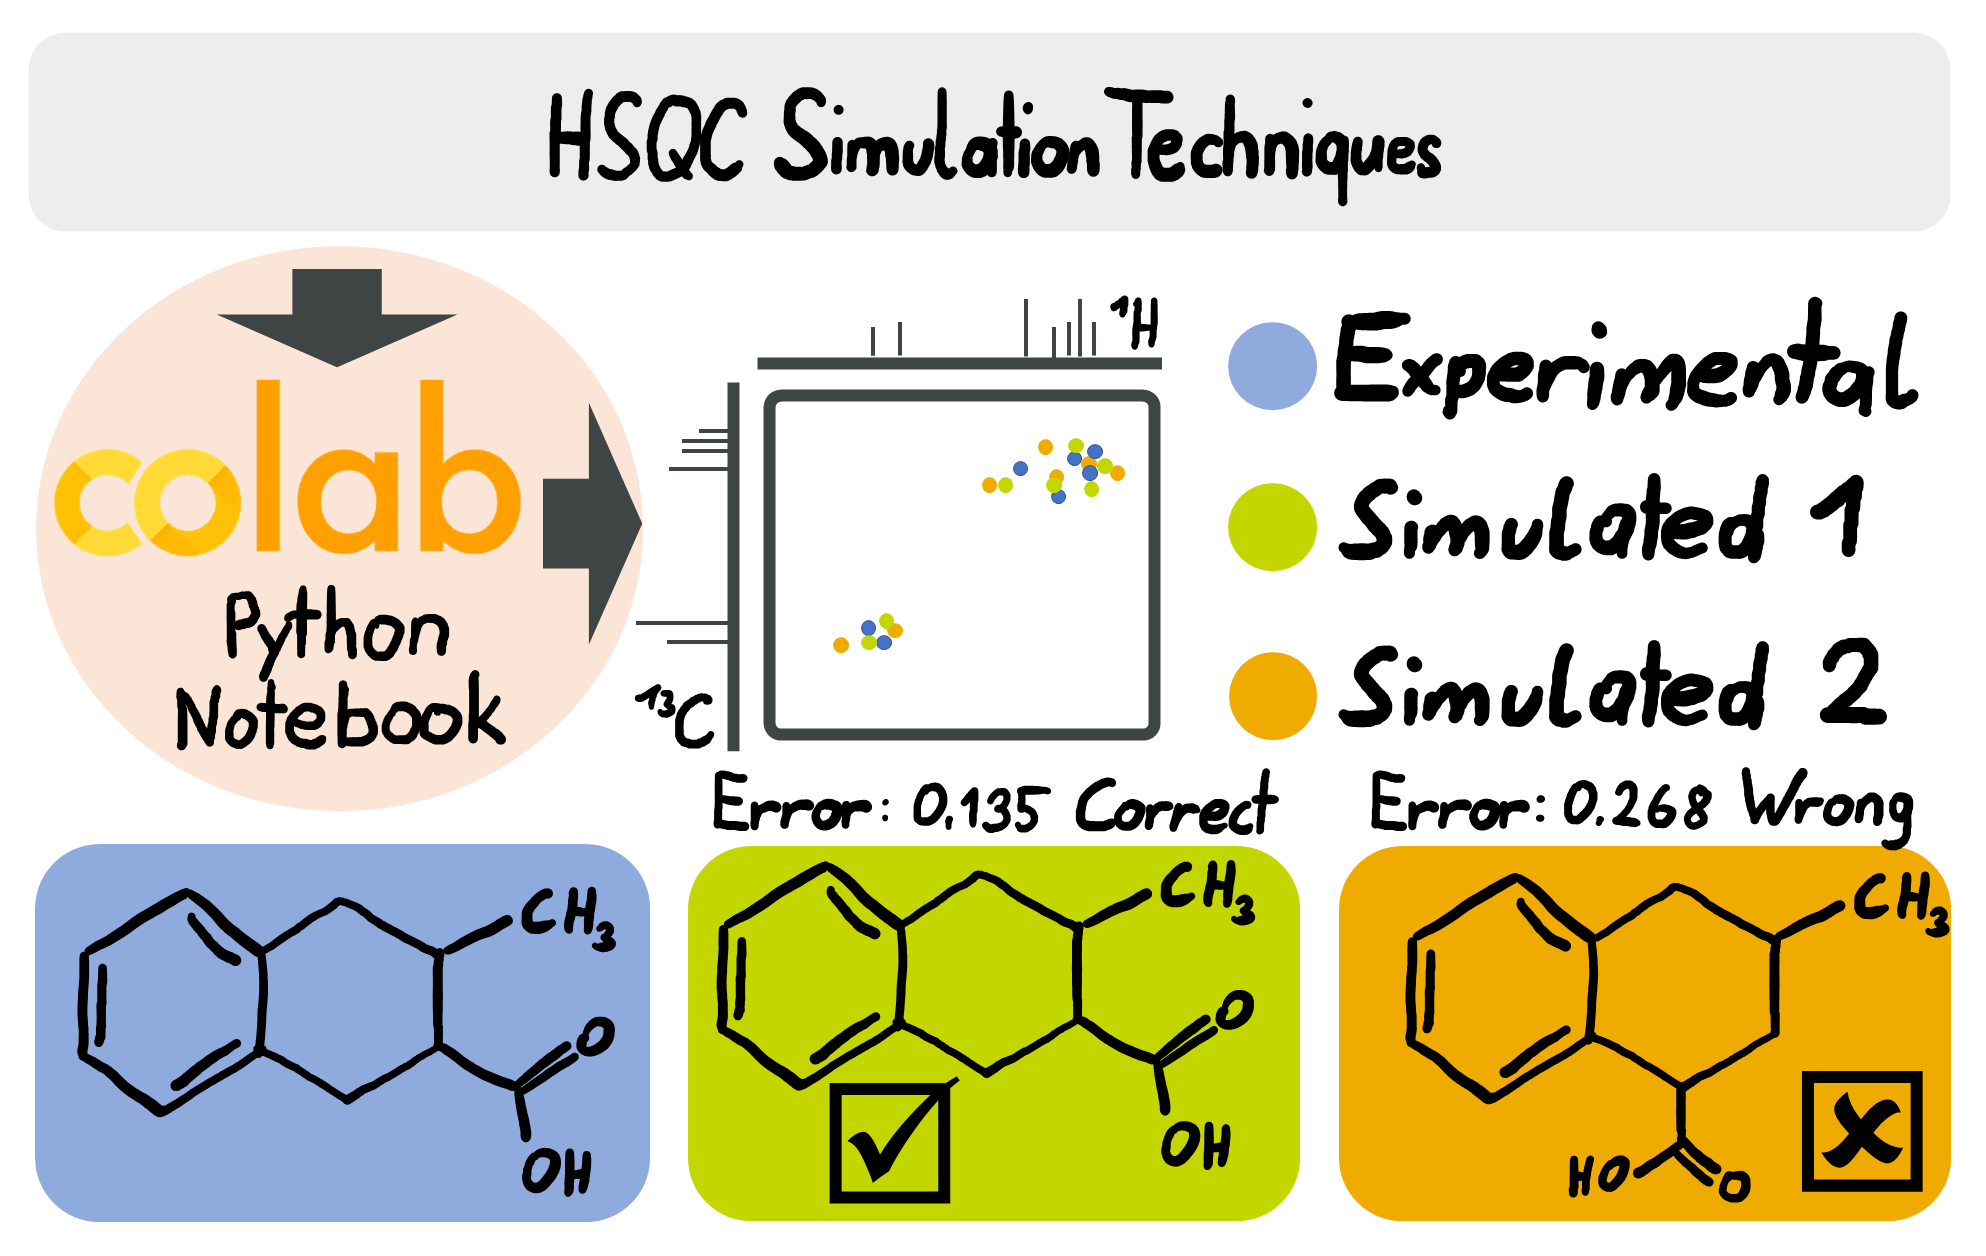
**Section 1**: This Notebook utilizes the SGNN graph-based neural network to simulate 1H and 13C NMR shifts from molecules.

- Implementation of the following paper: **Scalable graph neural network for NMR chemical shift prediction** [URL](https://pubs.rsc.org/en/Content/ArticleLanding/2022/CP/D2CP04542G)


 **Section 2**: Here, you can compare experimentally measured HSQC spectra with different simulated spectra to determine which structure of the simulated spectrum corresponds more closely to the experimental one. The notebook provides four different simulation techniques for spectrum simulation: ACD labs, MNova, DFT, and ML (SGNN) (for the latter two it uses a logic for HSQC peak reconstruction from 1H and 13C NMR shifts . Additionally, you have the option to choose different matching and padding strategies for the comparison algorithm.

- Implementation of the following paper: **Advancing  HSQC Spectral Matching: A Comparative Study of Peak-Matching and Simulation Techniques for Molecular Identification**  [URL](https://pubs.rsc.org/en/Content/ArticleLanding/2022/CP/D2CP04542G))

#**0.0 How to use this notebook?**
---

## **SGNN 1H & 13C NMR prediction & HSQC Evaluator**
- [**TUTORIAL Video**](https://youtu.be/w59bVTpJmZY): **WATCH THAT BEFORE USING IT**!!!

## **HSQC NMR Simulation Preparation**

- [**TUTORIAL Prepare MNova Simulated Data**](https://youtu.be/MHuDZbmByE0): **WATCH THAT BEFORE USING IT**!!!
- [**TUTORIAL: Prepare ACD Labs Simulated Data**](https://youtu.be/wCRrclBHpWE): **WATCH THAT BEFORE USING IT**!!!
- [**TUTORIAL Video Prepare Experimental Data**](https://youtu.be/NYW5bve198U): **WATCH THAT BEFORE USING IT**!!!

# **1. Initialise the Colab session**
---

In [ ]:
#@markdown ## **1.1. Mount your Google Drive**

#@markdown * Play the cell to connect your Google Drive to Colab

#@markdown * Click on the URL.

#@markdown * Sign in your Google Account.

#@markdown * Copy the authorization code.

#@markdown * Enter the authorization code.

#@markdown * Click on "Files" site on the right. Refresh the site. Your Google Drive folder should now be available here as "drive".

# mount user's Google Drive to Google Colab.
from google.colab import drive
drive.mount('/content/gdrive')
from IPython.display import clear_output


Mounted at /content/gdrive


In [ ]:
#@title ## **1.2. Install the requirements**
! wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
! chmod +x Miniconda3-py37_4.8.2-Linux-x86_64.sh
! bash ./Miniconda3-py37_4.8.2-Linux-x86_64.sh -b -f -p /usr/local
! conda install -c rdkit rdkit -y
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

! pip install torch==1.9.1+cu111 torchvision==0.10.1+cu111 torchaudio==0.9.1 -f https://download.pytorch.org/whl/torch_stable.html
! pip install dgl-cu111
! pip install -U scikit-learn
! pip install dgllife==0.3.0
! pip install cairosvg
! pip install rdkit
! git clone ssh://git@bitbucket.astrazeneca.net:7999/~knlr326/hsqc_structure_elucidation.git
! cd HSQC_structure_elucidation
# Move the nmr_sgnn folder up one directory
! mv nmr_sgnn ../

%cd "/content/nmr_sgnn"


In [ ]:
#@title ### Prevent Google Colab from Disconnecting
#@markdown #### Just press stop when you want to continue - this will break the waiting loop
import time
time.sleep(3600)

# **2. Perform NMR Prediction with SGNN Network**
---

This section provides an implementation of the following publication:

**Scalable graph neural network for NMR chemical shift prediction**  [URL](https://pubs.rsc.org/en/Content/ArticleLanding/2022/CP/D2CP04542G)

from *Jongmin Han, Hyungu Kang, Seokho Kang, Youngchun Kwon,
Dongseon Lee and Youn-Suk Choi*


 It is a modification of the original git repository found under the following link [URL](https://github.com/hjm9702/nmr_sgnn)

It provides an easy and quick way to simulate 1H and 13C NMR shifts from small molecules which can then be used for the HSQC reconstruction in **Section 3**.


In [ ]:
#@title ## **2.1. Load Functions SGNN**

import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')
from dgl.convert import graph
from IPython.display import display, SVG
import numpy as np
import os
from rdkit import Chem, RDConfig, rdBase
from rdkit.Chem import AllChem, ChemicalFeatures
import argparse
import ast

# target = "13C" #"1H"

atom_list = ['H','Li','B','C','N','O','F','Na','Mg','Al','Si','P','S','Cl','K','Ti','Zn','Ge','As','Se','Br','Pd','Ag','Sn','Sb','Te','I','Hg','Tl','Pb','Bi','Ga']
charge_list = [1, 2, 3, -1, -2, -3, 0]
degree_list = [1, 2, 3, 4, 5, 6, 0]
valence_list = [1, 2, 3, 4, 5, 6, 0]
hybridization_list = ['SP','SP2','SP3','SP3D','SP3D2','S','UNSPECIFIED']
hydrogen_list = [1, 2, 3, 4, 0]
ringsize_list = [3, 4, 5, 6, 7, 8]

bond_list = ['SINGLE', 'DOUBLE', 'TRIPLE', 'AROMATIC']
max_graph_distance = 20

rdBase.DisableLog('rdApp.error')
rdBase.DisableLog('rdApp.warning')
chem_feature_factory = ChemicalFeatures.BuildFeatureFactory(os.path.join(RDConfig.RDDataDir, 'BaseFeatures.fdef'))
mol_dict = {'n_node': [],
                'n_edge': [],
                'node_attr': [],
                'edge_attr': [],
                'src': [],
                'dst': [],
                'shift': [],
                'mask': [],
                'smi': [],
                'h_c_connectivity': []}


message_passing_mode = "proposed"
readout_mode = "proposed_set2set"
graph_representation = "sparsified"
# target = "13C"
memo = ""
fold_seed = 0
data_split = [0.95, 0.05]
batch_size = 128
random_seed = 27407
node_embedding_dim = 256
node_hidden_dim = 512
readout_n_hidden_dim = 512


# For showing molecule
from rdkit import Chem
from rdkit.Chem import AllChem
from collections import defaultdict
from rdkit.Chem import rdFMCS
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.drawOptions.addAtomIndices = True

#needed for show_mols
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG
import cairosvg
import math
import os

from rdkit import rdBase
rdBase.rdkitVersion


#inspired by https://github.com/rdkit/UGM_2020/blob/master/Notebooks/Landrum_WhatsNew.ipynb
def show_mols(mols, mols_per_row = 5, size=200, min_font_size=12, legends=[], file_name=''):
    if legends and len(legends) < len(mols):
      print('legends is too short')
      return None

    mols_per_row = min(len(mols), mols_per_row)
    rows = math.ceil(len(mols)/mols_per_row)
    d2d = rdMolDraw2D.MolDraw2DSVG(mols_per_row*size,rows*size,size,size)
    d2d.drawOptions().minFontSize = min_font_size
    if legends:
       d2d.DrawMolecules(mols, legends=legends)
    else:
        d2d.DrawMolecules(mols)
    d2d.FinishDrawing()

    if file_name:
      with open('d2d.svg', 'w') as f:
        f.write(d2d.GetDrawingText())
        if 'pdf' in file_name:
           cairosvg.svg2pdf(url='d2d.svg', write_to=file_name)
        else:
           cairosvg.svg2png(url='d2d.svg', write_to=file_name)
        os.remove('d2d.svg')

    return SVG(d2d.GetDrawingText())

from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG

def mol_with_atom_index(mol, include_H=True):
    """
    Takes a mol as input and adds H to them
    Visualizes the number which is assigned to which atom as a mol
    if include_H is True then H will be added and also labeled in the mol file
    """
    # mol = MolFromSmiles(smiles)
    if include_H:
        mol = Chem.AddHs(mol,addCoords=True)

    atoms = mol.GetNumAtoms()
    for idx in range( atoms ):
        mol.GetAtomWithIdx( idx ).SetProp( 'molAtomMapNumber', str( mol.GetAtomWithIdx( idx ).GetIdx() ) )
    return mol


def moltosvg(mol, molSize = (300,300), kekulize = True):
    mc = Chem.Mol(mol.ToBinary())
    if kekulize:
        try:
            Chem.Kekulize(mc)
        except:
            mc = Chem.Mol(mol.ToBinary())
    if not mc.GetNumConformers():
        rdDepictor.Compute2DCoords(mc)
    drawer = rdMolDraw2D.MolDraw2DSVG(molSize[0],molSize[1])
    drawer.DrawMolecule(mc)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    return svg.replace('svg:','')

import random
def mol2SDF(mol, folder=None, name=None):
    """ Saves a smile to a given folder with a given name/ID in sdf format
    adding the H is crutial for the ICOLOS workflow
    ir no name is provided then it saves it under a random number"""
    if name==None:
        rand_num = random.randint(0,1000)
        name = "%04d" % (rand_num)
    if folder==None:
        folder = os.getcwd() + "/trash"
        os.makedirs(folder, exist_ok=True)
    name = name+".sdf"
    save_path = os.path.join(folder,name)
    writer = Chem.SDWriter(save_path)
    writer.write(mol)
    writer.close()
    return save_path

    # Get the atom numbers that have hydrogens attached to it


def get_molecule_data(compound_path):
    """ This function returns the list of atoms of the molecules
    and a list of strings with each line of the compound document as one string
    because reading the SDF files with pandas causes an error"""

    ################ atom_list ################
    index_list_C =[]
    index_list_H =[]
    docline_list = []
    start = False
    name = compound_path.split("/")[-1].split(".")[0]

    # save each string line of the document in a list
    with open(compound_path) as f:
        for i in f:
            docline_list.append(i)

    # get index location of C and H and atom list
    atom_list = []
    stop_list = ["1","0","2","3","4","5","6","7","8","9","10","11","12","13","14","15"]
    for i in docline_list:

        if start:
            if "C" in i:
                index_list_C.append(counter)
            if "H" in i:
                index_list_H.append(counter)
            if (i.split()[0] in stop_list):   # to find the end of the atom defining list
                break
            atom = i.split()[3]
            if atom != "0":
                atom_list.append(atom)
                counter += 1

        if "V2000" in i:   # select when to start looking
            start = True
            counter = 0

    ################ connectivity_list ################
    # # To get the reference right add one empty string to the list -> need to check that there is something wrong
    # atom_list_ = [" "] + atom_list
    atom_list_ = atom_list
    start_line = len(atom_list_)+4
    end_line = len(atom_list_)+4 + len(atom_list_)
    connectivity_list = []

    for idx, i in enumerate(docline_list):
        if idx >= start_line and "M  END" not in i:
            add_list = i.split()
            ### if there are more than 100 connection the first and second columns are connected
            ### therefore I need to manually split them
            if len(add_list) ==3:
                part_1 = str(int(i[:3]))
                part_2 = str(int(i[3:6]))
                part_3 = str(int(i[6:9]))
                part_4 = str(int(i[9:12]))
                add_list =[part_1,part_2,part_3,part_4]

            ### For some reason sometimes it is too long and sometimes it is too short
            if add_list[0]=="M" or add_list[0]==">" or add_list[0]=="$$$$":
                pass
            else:
                connectivity_list.append(add_list)
        if  "M  END" in i:
            break
    ################ mol ################
    # save each string line of the document in a list
    with open(compound_path[:-4]+".mol", "w",  encoding='utf-8', errors='ignore') as output:  # Path to broken file
        with open(compound_path) as f:
            for element in f:
                if "END" in element:
                    output.write(element)
                    break
                else:
                    output.write(element)

    mol = Chem.MolFromMolFile(compound_path[:-4]+".mol")
    return atom_list, connectivity_list, docline_list, name, mol


# Get C-H connectivity dict with index starting from 0 to correct it to python convention
def get_x_h_connectivity(connectivity_list, atom_list):
    """ This function checks the connectifity list and creates a dictionary with all the
    X atoms that are connected to hydrogens with their labelled numbers"""
    x_h_connectivity_dict = {}
    # print(connectivity_list)
    for i in connectivity_list:
        selected_atom_nr = int(i[0])-1
        selected_connection_nr = int(i[1])-1
        atom = atom_list[selected_atom_nr]
        connection = atom_list[selected_connection_nr]
        num_connection = atom_list[int(i[2])]
        # print(atom, selected_atom_nr, connection, selected_connection_nr)
        # check atom X-H bonds and add them to dictionary
        if (atom =="O" or atom =="S" or atom =="N" or atom =="P" or atom == "C") and connection == "H":
            found_H_nr = [selected_connection_nr]
            found_X_nr = selected_atom_nr
            try:
                # if there is no carbon in the dict yet it will fail and go to except
                type(x_h_connectivity_dict[found_X_nr]) == list
                x_h_connectivity_dict[found_X_nr]+=found_H_nr
            except:
                x_h_connectivity_dict[found_X_nr]=found_H_nr
        # check atom X-H bonds and add them to dictionary
        if atom =="H" and (connection =="O" or connection =="S" or connection =="N" or connection =="P" or connection =="C"):
            found_X_nr = selected_connection_nr
            found_H_nr = [selected_atom_nr]
            try:
                # if there is no carbon in the dict yet it will fail and go to except
                type(x_h_connectivity_dict[found_X_nr]) == list
                x_h_connectivity_dict[found_X_nr]+=found_H_nr
            except:
                x_h_connectivity_dict[found_X_nr]=found_H_nr

    return x_h_connectivity_dict


def _DA(mol):

    D_list, A_list = [], []
    for feat in chem_feature_factory.GetFeaturesForMol(mol):
        if feat.GetFamily() == 'Donor': D_list.append(feat.GetAtomIds()[0])
        if feat.GetFamily() == 'Acceptor': A_list.append(feat.GetAtomIds()[0])

    return D_list, A_list

def _chirality(atom):

    if atom.HasProp('Chirality'):
        c_list = [(atom.GetProp('Chirality') == 'Tet_CW'), (atom.GetProp('Chirality') == 'Tet_CCW')]
    else:
        c_list = [0, 0]

    return c_list


def _stereochemistry(bond):

    if bond.HasProp('Stereochemistry'):
        s_list = [(bond.GetProp('Stereochemistry') == 'Bond_Cis'), (bond.GetProp('Stereochemistry') == 'Bond_Trans')]
    else:
        s_list = [0, 0]

    return s_list


def add_mol_sparsified_graph(mol_dict, mol):

    n_node = mol.GetNumAtoms()
    n_edge = mol.GetNumBonds() * 2

    D_list, A_list = _DA(mol)

    atom_fea1 = np.eye(len(atom_list), dtype = bool)[[atom_list.index(a.GetSymbol()) for a in mol.GetAtoms()]]
    atom_fea2 = np.eye(len(charge_list), dtype = bool)[[charge_list.index(a.GetFormalCharge()) for a in mol.GetAtoms()]][:,:-1]
    atom_fea3 = np.eye(len(degree_list), dtype = bool)[[degree_list.index(a.GetDegree()) for a in mol.GetAtoms()]][:,:-1]
    atom_fea4 = np.eye(len(hybridization_list), dtype = bool)[[hybridization_list.index(str(a.GetHybridization())) for a in mol.GetAtoms()]][:,:-2]
    atom_fea5 = np.eye(len(hydrogen_list), dtype = bool)[[hydrogen_list.index(a.GetTotalNumHs(includeNeighbors=True)) for a in mol.GetAtoms()]][:,:-1]
    atom_fea6 = np.eye(len(valence_list), dtype = bool)[[valence_list.index(a.GetTotalValence()) for a in mol.GetAtoms()]][:,:-1]
    atom_fea7 = np.array([[(j in D_list), (j in A_list)] for j in range(mol.GetNumAtoms())], dtype = bool)
    atom_fea8 = np.array([_chirality(a) for a in mol.GetAtoms()], dtype = bool)
    atom_fea9 = np.array([[a.IsInRingSize(s) for s in ringsize_list] for a in mol.GetAtoms()], dtype = bool)
    atom_fea10 = np.array([[a.GetIsAromatic(), a.IsInRing()] for a in mol.GetAtoms()], dtype = bool)
    node_attr = np.concatenate([atom_fea1, atom_fea2, atom_fea3, atom_fea4, atom_fea5, atom_fea6, atom_fea7, atom_fea8, atom_fea9, atom_fea10], 1)

    shift = np.array([ast.literal_eval(atom.GetProp('shift')) for atom in mol.GetAtoms()])
    mask = np.array([atom.GetBoolProp('mask') for atom in mol.GetAtoms()])

    mol_dict['n_node'].append(n_node)
    mol_dict['n_edge'].append(n_edge)
    mol_dict['node_attr'].append(node_attr)

    mol_dict['shift'].append(shift)
    mol_dict['mask'].append(mask)
    mol_dict['smi'].append(Chem.MolToSmiles(mol))

    if n_edge > 0:

        bond_fea1 = np.eye(len(bond_list), dtype = bool)[[bond_list.index(str(b.GetBondType())) for b in mol.GetBonds()]]
        bond_fea2 = np.array([_stereochemistry(b) for b in mol.GetBonds()], dtype = bool)
        bond_fea3 = [[b.IsInRing(), b.GetIsConjugated()] for b in mol.GetBonds()]

        edge_attr = np.array(np.concatenate([bond_fea1, bond_fea2, bond_fea3], 1), dtype = bool)
        edge_attr = np.vstack([edge_attr, edge_attr])

        bond_loc = np.array([[b.GetBeginAtomIdx(), b.GetEndAtomIdx()] for b in mol.GetBonds()], dtype = int)
        src = np.hstack([bond_loc[:,0], bond_loc[:,1]])
        dst = np.hstack([bond_loc[:,1], bond_loc[:,0]])

        mol_dict['edge_attr'].append(edge_attr)
        mol_dict['src'].append(src)
        mol_dict['dst'].append(dst)

    return mol_dict


def add_mol_sparsified_graph(mol_dict, mol):

    n_node = mol.GetNumAtoms()
    n_edge = mol.GetNumBonds() * 2

    D_list, A_list = _DA(mol)

    atom_fea1 = np.eye(len(atom_list), dtype = bool)[[atom_list.index(a.GetSymbol()) for a in mol.GetAtoms()]]
    atom_fea2 = np.eye(len(charge_list), dtype = bool)[[charge_list.index(a.GetFormalCharge()) for a in mol.GetAtoms()]][:,:-1]
    atom_fea3 = np.eye(len(degree_list), dtype = bool)[[degree_list.index(a.GetDegree()) for a in mol.GetAtoms()]][:,:-1]
    atom_fea4 = np.eye(len(hybridization_list), dtype = bool)[[hybridization_list.index(str(a.GetHybridization())) for a in mol.GetAtoms()]][:,:-2]
    atom_fea5 = np.eye(len(hydrogen_list), dtype = bool)[[hydrogen_list.index(a.GetTotalNumHs(includeNeighbors=True)) for a in mol.GetAtoms()]][:,:-1]
    atom_fea6 = np.eye(len(valence_list), dtype = bool)[[valence_list.index(a.GetTotalValence()) for a in mol.GetAtoms()]][:,:-1]
    atom_fea7 = np.array([[(j in D_list), (j in A_list)] for j in range(mol.GetNumAtoms())], dtype = bool)
    atom_fea8 = np.array([_chirality(a) for a in mol.GetAtoms()], dtype = bool)
    atom_fea9 = np.array([[a.IsInRingSize(s) for s in ringsize_list] for a in mol.GetAtoms()], dtype = bool)
    atom_fea10 = np.array([[a.GetIsAromatic(), a.IsInRing()] for a in mol.GetAtoms()], dtype = bool)
    node_attr = np.concatenate([atom_fea1, atom_fea2, atom_fea3, atom_fea4, atom_fea5, atom_fea6, atom_fea7, atom_fea8, atom_fea9, atom_fea10], 1)

    shift = np.array([ast.literal_eval(atom.GetProp('shift')) for atom in mol.GetAtoms()])
    mask = np.array([atom.GetBoolProp('mask') for atom in mol.GetAtoms()])

    mol_dict['n_node'].append(n_node)
    mol_dict['n_edge'].append(n_edge)
    mol_dict['node_attr'].append(node_attr)

    mol_dict['shift'].append(shift)
    mol_dict['mask'].append(mask)
    mol_dict['smi'].append(Chem.MolToSmiles(mol))

    if n_edge > 0:

        bond_fea1 = np.eye(len(bond_list), dtype = bool)[[bond_list.index(str(b.GetBondType())) for b in mol.GetBonds()]]
        bond_fea2 = np.array([_stereochemistry(b) for b in mol.GetBonds()], dtype = bool)
        bond_fea3 = [[b.IsInRing(), b.GetIsConjugated()] for b in mol.GetBonds()]

        edge_attr = np.array(np.concatenate([bond_fea1, bond_fea2, bond_fea3], 1), dtype = bool)
        edge_attr = np.vstack([edge_attr, edge_attr])

        bond_loc = np.array([[b.GetBeginAtomIdx(), b.GetEndAtomIdx()] for b in mol.GetBonds()], dtype = int)
        src = np.hstack([bond_loc[:,0], bond_loc[:,1]])
        dst = np.hstack([bond_loc[:,1], bond_loc[:,0]])

        mol_dict['edge_attr'].append(edge_attr)
        mol_dict['src'].append(src)
        mol_dict['dst'].append(dst)

    return mol_dict

# Python code to merge dict using a single
# expression
def Merge(dict1, dict2):
    res = {**dict1, **dict2}
    return res



import numpy as np
import torch
from dgl.convert import graph


class GraphDataset_sample():

    def __init__(self, target, file_path):

        self.target = target
        # self.graph_representation = graph_representation
        self.split = None
        self.file_path = file_path
        self.load()


    def load(self):
        if self.target == "13C":
            [mol_dict] = np.load(self.file_path, allow_pickle=True)['data']
        elif self.target == "1H":
            [mol_dict] = np.load(self.file_path, allow_pickle=True)['data']
            self.h_x_connectivity = mol_dict['h_x_connectivity']

        self.n_node = mol_dict['n_node']
        self.n_edge = mol_dict['n_edge']
        self.node_attr = mol_dict['node_attr']
        self.edge_attr = mol_dict['edge_attr']
        self.src = mol_dict['src']
        self.dst = mol_dict['dst']

        self.shift = mol_dict['shift']
        self.mask = mol_dict['mask']
        self.smi = mol_dict['smi']


        self.n_csum = np.concatenate([[0], np.cumsum(self.n_node)])
        self.e_csum = np.concatenate([[0], np.cumsum(self.n_edge)])


    def __getitem__(self, idx):
        g = graph((self.src[self.e_csum[idx]:self.e_csum[idx+1]], self.dst[self.e_csum[idx]:self.e_csum[idx+1]]), num_nodes = self.n_node[idx])
        g.ndata['node_attr'] = torch.from_numpy(self.node_attr[self.n_csum[idx]:self.n_csum[idx+1]]).float()
        g.edata['edge_attr'] = torch.from_numpy(self.edge_attr[self.e_csum[idx]:self.e_csum[idx+1]]).float()

        n_node = self.n_node[idx:idx+1].astype(int)
        numHshifts = np.zeros(n_node)
        shift = self.shift[self.n_csum[idx]:self.n_csum[idx+1]]#.astype(float)
        shift_test = shift
        mask = self.mask[self.n_csum[idx]:self.n_csum[idx+1]].astype(bool)

        ### Fill with all zeros for inference on new sample
        if self.target == '1H':

            shift = np.hstack([0.0 for s in self.shift[idx]])
            numHshifts = np.hstack([len(s) for s in self.h_x_connectivity[idx].values()])
            shift_test = np.hstack([np.hstack([0.0 for i in range(len(s))]) for s in self.h_x_connectivity[0].values() if len(s) > 0])
            # shift_test = np.append(shift_test,[0.])
        return g, n_node, numHshifts, shift_test, shift, mask


    def __len__(self):

        return self.n_node.shape[0]


########################################## General ##########################################
# Load Model
from gnn_models.mpnn_proposed import nmr_mpnn_PROPOSED
from gnn_models.mpnn_baseline import nmr_mpnn_BASELINE

import numpy as np
import os
from rdkit import Chem, RDConfig, rdBase
from rdkit.Chem import AllChem, ChemicalFeatures
import argparse
import ast
from model import training, inference
from dataset import GraphDataset

from dataset import GraphDataset
from dgllife.utils import RandomSplitter
from dgl.data.utils import split_dataset
from util import collate_reaction_graphs
from torch.utils.data import DataLoader
from model import training, inference


def load_std_mean(target,graph_representation):
    """This functions returns the train_y_mean, train_y_std of the train dataset for either H or C"""
    #Load Train data (to get the train_y_mean and std)
    batch_size = 128
    data = GraphDataset(target, graph_representation)
    all_train_data_loader_C = DataLoader(dataset=data, batch_size=batch_size, shuffle=True, collate_fn=collate_reaction_graphs, drop_last=True)
    train_y = np.hstack([inst[-2][inst[-1]] for inst in iter(all_train_data_loader_C.dataset)])
    train_y_mean, train_y_std = np.mean(train_y), np.std(train_y)
    # print(train_y_mean, train_y_std)
    return train_y_mean, train_y_std

def load_model(target, save_path):
    """ """
    data_sample = GraphDataset_sample(target, save_path)

    node_dim = data_sample.node_attr.shape[1]
    edge_dim = data_sample.edge_attr.shape[1]
    net = nmr_mpnn_PROPOSED(node_dim, edge_dim, readout_mode, node_embedding_dim, readout_n_hidden_dim).cuda()

    if target == "1H":
        model_path = "/content/gdrive/MyDrive/1.2_BIG_DATA_PhD_Project_2/10.Astrazeneca/Paper_1_data/nmr_sgnn/model/1H_sparsified_proposed_proposed_set2set_1.pt"
        net.load_state_dict(torch.load(model_path))
    elif target == "13C":
        model_path = "/content/gdrive/MyDrive/1.2_BIG_DATA_PhD_Project_2/10.Astrazeneca/Paper_1_data/nmr_sgnn/model/13C_sparsified_proposed_proposed_set2set_1.pt"
        net.load_state_dict(torch.load(model_path))
    return net

########################################## C related ##########################################

def save_as_npy_for_13C(mol):
    """ This functions executes all the code for creating the npy file for inference"""
    target = "13C" #"1H"

    atom_list = ['H','Li','B','C','N','O','F','Na','Mg','Al','Si','P','S','Cl','K','Ti','Zn','Ge','As','Se','Br','Pd','Ag','Sn','Sb','Te','I','Hg','Tl','Pb','Bi','Ga']
    charge_list = [1, 2, 3, -1, -2, -3, 0]
    degree_list = [1, 2, 3, 4, 5, 6, 0]
    valence_list = [1, 2, 3, 4, 5, 6, 0]
    hybridization_list = ['SP','SP2','SP3','SP3D','SP3D2','S','UNSPECIFIED']
    hydrogen_list = [1, 2, 3, 4, 0]
    ringsize_list = [3, 4, 5, 6, 7, 8]

    bond_list = ['SINGLE', 'DOUBLE', 'TRIPLE', 'AROMATIC']
    max_graph_distance = 20

    rdBase.DisableLog('rdApp.error')
    rdBase.DisableLog('rdApp.warning')
    chem_feature_factory = ChemicalFeatures.BuildFeatureFactory(os.path.join(RDConfig.RDDataDir, 'BaseFeatures.fdef'))
    mol_dict = {'n_node': [],
                    'n_edge': [],
                    'node_attr': [],
                    'edge_attr': [],
                    'src': [],
                    'dst': [],
                    'shift': [],
                    'mask': [],
                    'smi': [],
                    # 'h_c_connectivity': [],
                    'h_x_connectivity': []}

    message_passing_mode = "proposed"
    readout_mode = "proposed_set2set"
    graph_representation = "sparsified"
    target = "13C"
    memo = ""
    fold_seed = 0
    data_split = [0.95, 0.05]
    batch_size = 128
    random_seed = 27407
    node_embedding_dim = 256
    node_hidden_dim = 512
    readout_n_hidden_dim = 512



    Chem.SanitizeMol(mol)
    si = Chem.FindPotentialStereo(mol)
    for element in si:
        if str(element.type) == 'Atom_Tetrahedral' and str(element.specified) == 'Specified':
            mol.GetAtomWithIdx(element.centeredOn).SetProp('Chirality', str(element.descriptor))
        elif str(element.type) == 'Bond_Double' and str(element.specified) == 'Specified':
            mol.GetBondWithIdx(element.centeredOn).SetProp('Stereochemistry', str(element.descriptor))
    assert '.' not in Chem.MolToSmiles(mol)

    # Write dummy shift (0.0) into the shift property and set mask for carbons True
    atom_selection_list = ["C"]#"H"
    for j, atom in enumerate(mol.GetAtoms()):
        if atom.GetSymbol() in atom_selection_list:
            atom.SetProp('shift', str(0.0))
            atom.SetBoolProp('mask', 1)
        else:
            atom.SetProp('shift', str(0.0))
            atom.SetBoolProp('mask', 0)

    mol = Chem.RemoveHs(mol)
    mol_dict = add_mol_sparsified_graph(mol_dict, mol)

    mol_dict['n_node'] = np.array(mol_dict['n_node']).astype(int)
    mol_dict['n_edge'] = np.array(mol_dict['n_edge']).astype(int)
    mol_dict['node_attr'] = np.vstack(mol_dict['node_attr']).astype(bool)
    mol_dict['edge_attr'] = np.vstack(mol_dict['edge_attr']).astype(bool)
    mol_dict['src'] = np.hstack(mol_dict['src']).astype(int)
    mol_dict['dst'] = np.hstack(mol_dict['dst']).astype(int)
    if target == '13C': mol_dict['shift'] = np.hstack(mol_dict['shift'])
    mol_dict['mask'] = np.hstack(mol_dict['mask']).astype(bool)
    mol_dict['smi'] = np.array(mol_dict['smi'])

    #save the paramenters
    # for key in mol_dict.keys(): print(key, mol_dict[key].shape, mol_dict[key].dtype)
    folder = os.getcwd()
    save_path = os.path.join(folder, "sample_%s.npz"%(target))
    np.savez_compressed('./sample_%s.npz'%(target), data = [mol_dict])
    return save_path



def inference_C(net, save_path, train_y_mean_C, train_y_std_C):
    # Load data sample
    target = "13C"
    data_sample = GraphDataset_sample(target, save_path)
    test_sample_loader = DataLoader(dataset=data_sample, batch_size=batch_size, shuffle=False, collate_fn=collate_reaction_graphs)

    # inference
    test_y_pred_C, time_per_mol_C = inference(net, test_sample_loader, train_y_mean_C, train_y_std_C)
    return test_y_pred_C


########################################## H related ##########################################

def save_as_npy_for_1H(mol):

    ### Generate SDF File
    mol = Chem.AddHs(mol, addCoords=True)
    sdf_path = mol2SDF(mol)

    ### Generate connectivity list
    atom_list, connectivity_list, docline_list, name, mol = get_molecule_data(sdf_path)
    # c_h_connectivity_dict = get_c_h_connectivity(connectivity_list, atom_list)
    x_h_connectivity_dict = get_x_h_connectivity(connectivity_list, atom_list)


    target = "1H" #"13C"

    atom_list = ['H','Li','B','C','N','O','F','Na','Mg','Al','Si','P','S','Cl','K','Ti','Zn','Ge','As','Se','Br','Pd','Ag','Sn','Sb','Te','I','Hg','Tl','Pb','Bi','Ga']
    charge_list = [1, 2, 3, -1, -2, -3, 0]
    degree_list = [1, 2, 3, 4, 5, 6, 0]
    valence_list = [1, 2, 3, 4, 5, 6, 0]
    hybridization_list = ['SP','SP2','SP3','SP3D','SP3D2','S','UNSPECIFIED']
    hydrogen_list = [1, 2, 3, 4, 0]
    ringsize_list = [3, 4, 5, 6, 7, 8]

    bond_list = ['SINGLE', 'DOUBLE', 'TRIPLE', 'AROMATIC']
    max_graph_distance = 20

    rdBase.DisableLog('rdApp.error')
    rdBase.DisableLog('rdApp.warning')
    chem_feature_factory = ChemicalFeatures.BuildFeatureFactory(os.path.join(RDConfig.RDDataDir, 'BaseFeatures.fdef'))

    mol_dict = {'n_node': [],
                    'n_edge': [],
                    'node_attr': [],
                    'edge_attr': [],
                    'src': [],
                    'dst': [],
                    'shift': [],
                    'mask': [],
                    'smi': [],
                    # 'h_c_connectivity': [],
                    'h_x_connectivity': []}

    target = "1H"
    message_passing_mode = "proposed"
    readout_mode = "proposed_set2set"
    graph_representation = "sparsified"
    memo = ""
    fold_seed = 0
    #model_path = "/projects/cc/knlr326/2_git_repos/ml_nmr_prediction/Jongmin_Han/nmr_sgnn/model/1H_sparsified_proposed_proposed_set2set_1.pt"
    data_split = [0.95, 0.05]
    batch_size = 128
    random_seed = 27407

    node_embedding_dim = 256
    node_hidden_dim = 512
    readout_n_hidden_dim = 512

    ### Check on Mol
    mol = Chem.RemoveHs(mol)
    Chem.SanitizeMol(mol)
    si = Chem.FindPotentialStereo(mol)
    for element in si:
        if str(element.type) == 'Atom_Tetrahedral' and str(element.specified) == 'Specified':
            mol.GetAtomWithIdx(element.centeredOn).SetProp('Chirality', str(element.descriptor))
        elif str(element.type) == 'Bond_Double' and str(element.specified) == 'Specified':
            mol.GetBondWithIdx(element.centeredOn).SetProp('Stereochemistry', str(element.descriptor))
    assert '.' not in Chem.MolToSmiles(mol)

    # Filter to get just the atoms that are connected to hydrogens
    H_ID_list = [k for k,v in x_h_connectivity_dict.items() if v !=[] ]

    # Set shift = 0.0 for all C where H is connected
    for j, atom in enumerate(mol.GetAtoms()):
        if atom.GetIdx() in H_ID_list:
            atom.SetProp('shift', str(0.0))
            atom.SetBoolProp('mask', 1)
        else:
            atom.SetProp('shift', str(0.0))
            atom.SetBoolProp('mask', 0)

    # generate Mol_dict with all the information
    mol_dict = add_mol_sparsified_graph(mol_dict, mol)
    mol_dict['n_node'] = np.array(mol_dict['n_node']).astype(int)
    mol_dict['n_edge'] = np.array(mol_dict['n_edge']).astype(int)
    mol_dict['node_attr'] = np.vstack(mol_dict['node_attr']).astype(bool)
    mol_dict['edge_attr'] = np.vstack(mol_dict['edge_attr']).astype(bool)
    mol_dict['src'] = np.hstack(mol_dict['src']).astype(int)
    mol_dict['dst'] = np.hstack(mol_dict['dst']).astype(int)
    if target == '1H': mol_dict['shift'] = np.array(mol_dict['shift'])
    mol_dict['mask'] = np.hstack(mol_dict['mask']).astype(bool)
    mol_dict['smi'] = np.array(mol_dict['smi'])
    # mol_dict["h_c_connectivity"].append(c_h_connectivity_dict)
    mol_dict["h_x_connectivity"].append(x_h_connectivity_dict)


    #save the paramenters
    folder = os.getcwd()
    save_path = os.path.join(folder, "sample_%s.npz"%(target))
    np.savez_compressed('./sample_%s.npz'%(target), data = [mol_dict])
    return save_path, x_h_connectivity_dict



def inference_H(net, save_path, train_y_mean_H, train_y_std_H):
    # Load data sample
    target = "1H" #"13C"
    data_sample = GraphDataset_sample(target, save_path)
    test_sample_loader = DataLoader(dataset=data_sample, batch_size=batch_size, shuffle=False, collate_fn=collate_reaction_graphs)

    # inference
    test_y_pred_H, time_per_mol_H = inference(net, test_sample_loader, train_y_mean_H, train_y_std_H)
    return test_y_pred_H

########################################## Reconstruct ##########################################

def create_shift_list(mol, x_h_connectivity_dict, test_y_pred_C, test_y_pred_H):
    """This function recreates the shift list based on the index labelling of the molecule (including H atoms)"""
    final_list = []
    c_count = 0
    h_count = 0
    h_done = []
    for idx, atom in enumerate(mol.GetAtoms()):
      # print(idx, atom.GetSymbol())

      if atom.GetSymbol() == "C":
        final_list.append(test_y_pred_C[c_count])
        c_count += 1

      elif atom.GetSymbol() == "H":
        # Check if the ID is in the connectivity list of the
        for k,v in x_h_connectivity_dict.items():
          if idx in v and idx not in h_done:
            for i in v:           # iterate over the number of H and add them to list and also to done list
              final_list.append(test_y_pred_H[h_count])
              h_done.append(i)
            h_count += 1
      else:
        final_list.append(0)
    return final_list



def get_shift_string(assigned_shifts):
    """ This function just converts the the nmr shifts to one long
    string that can ve saved in the sdf file"""
    string = ""
    for idx,shift in enumerate(assigned_shifts):
        string = string + " " + str(shift)
    final_string = string[1:]+"\n"
    return final_string


def save_results_sdf_file(mol, save_folder, ID, final_list):
    """ This function saves the final shift predictions into a SDF files with the lowest energy conformer"""

    sdf_path = mol2SDF(mol, save_folder, ID)

    name = "NMR_" + str(ID)+".sdf"
    output_sdf = os.path.join(save_folder,name)
    with open(output_sdf, "w",  encoding='utf-8', errors='ignore') as output:
        print(sdf_path)
        with open(sdf_path) as g:
            for i in g:
                output.write(i)
                if i == 'M  END\n':
                    output.write("\n")
                    output.write(f">  <averaged_NMR_shifts>  ({1}) \n")
                    shifts_string = get_shift_string(final_list)
                    output.write(shifts_string)
                    output.write("\n")
    g.close()
    output.close()
    return output_sdf


def main_execute(data_df, save_folder):
    """ Given a pandas dataframe with columns SMILES and sample-id it calculates
    all the sdf files including the nmr shifts for every C and H atom"""
    ############## General ##############
    graph_representation = "sparsified"
    target = "13C"
    train_y_mean_C, train_y_std_C = load_std_mean(target,graph_representation)
    target = "1H"
    train_y_mean_H, train_y_std_H = load_std_mean(target,graph_representation)

    SMILES_list = data_df["SMILES"]
    sample_id = data_df["sample-id"]

    for smi, ID in tqdm(zip(SMILES_list[:],sample_id[:])):
        print(smi, ID)
        ID = str(ID)
        mol = MolFromSmiles(smi)
        ############## For 13C ##############
        target = "13C"
        save_path_C = save_as_npy_for_13C(mol)
        net_C = load_model(target, save_path_C)
        test_y_pred_C = inference_C(net_C, save_path_C, train_y_mean_C, train_y_std_C)

        ############## For 1H ##############
        target = "1H"
        save_path_H, x_h_connectivity_dict = save_as_npy_for_1H(mol)
        net_H = load_model(target, save_path_H)
        test_y_pred_H = inference_H(net_H, save_path_H, train_y_mean_H, train_y_std_H)

        ############## Reconstruction ##############

        mol = Chem.AddHs(mol)
        final_list = create_shift_list(mol, x_h_connectivity_dict, test_y_pred_C, test_y_pred_H)

        output_sdf = save_results_sdf_file(mol, save_folder, ID, final_list)
        print(output_sdf)#

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


Using backend: pytorch


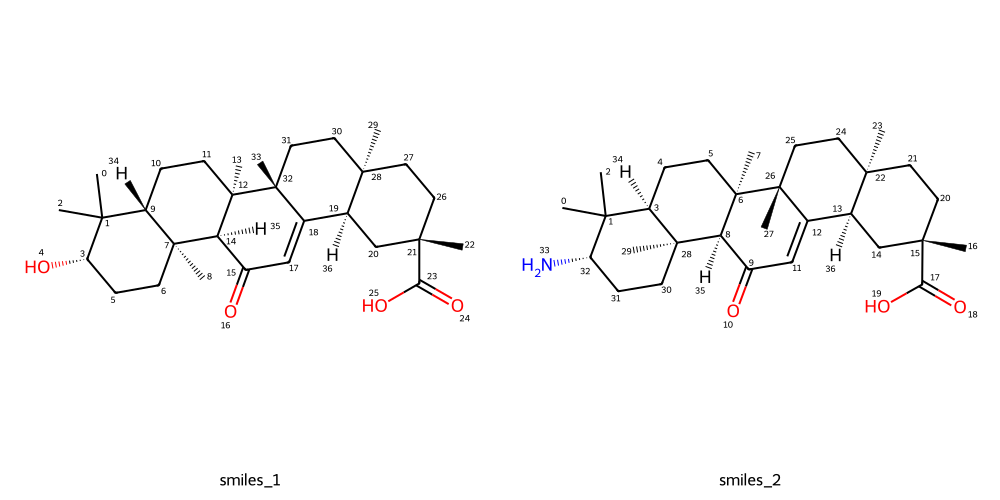

0it [00:00, ?it/s]

CC1(C)[C@@H](O)CC[C@@]2(C)[C@H]1CC[C@]1(C)[C@H]2C(=O)C=C2[C@@H]3C[C@@](C)(C(=O)O)CC[C@]3(C)CC[C@]21C smiles_1


1it [00:01,  1.83s/it]

/content/sample/smiles_1.sdf
/content/sample/NMR_smiles_1.sdf
CC1(C)[C@H]2CC[C@]3(C)[C@@H](C(=O)C=C4[C@@H]5C[C@@](C)(C(=O)O)CC[C@]5(C)CC[C@]43C)[C@@]2(C)CC[C@@H]1N smiles_2


2it [00:04,  2.03s/it]

/content/sample/smiles_2.sdf
/content/sample/NMR_smiles_2.sdf


In [ ]:
#@title ## **2.2. Run ML NMR Calculations with SGNN Network**
#@markdown ### The CSV file needs to have the following two columns: "SMILES" and "sample-id"
import pandas as pd
from tqdm import tqdm
import glob
from rdkit.Chem import MolFromSmiles

smiles_1 = "CC1(C)[C@@H](O)CC[C@@]2(C)[C@H]1CC[C@]1(C)[C@H]2C(=O)C=C2[C@@H]3C[C@@](C)(C(=O)O)CC[C@]3(C)CC[C@]21C"#@param {type:"string"}
smiles_2 = "CC1(C)[C@H]2CC[C@]3(C)[C@@H](C(=O)C=C4[C@@H]5C[C@@](C)(C(=O)O)CC[C@]5(C)CC[C@]43C)[C@@]2(C)CC[C@@H]1N"#@param {type:"string"}
names = ["smiles_1", "smiles_2"]
smiles = [smiles_1, smiles_2]

mol1 = Chem.MolFromSmiles(smiles_1)
mol2 = Chem.MolFromSmiles(smiles_2)
img = Draw.MolsToGridImage([mol1,mol2], legends=names, molsPerRow=2, subImgSize=(500, 500)) # increase the tuple numbers for bigger image

# Display the image
display(img)

# Create a DataFrame
df = pd.DataFrame({
    'SMILES': smiles,
    'sample-id': names})

# Save the DataFrame to a CSV file
path_csv = '/content/path_to_your_file.csv'
df.to_csv(path_csv, index=False)

#path_csv = "/content/nmr_sgnn/id_smiles.csv"#@param {type:"string"}
ML_save_folder = "/content/sample"#@param {type:"string"}
if not os.path.exists(ML_save_folder):
  os.mkdir(ML_save_folder)

data_df = pd.read_csv(path_csv)
main_execute(data_df, ML_save_folder)




# **3. Perform HSQC NMR Evaluation**
---


This notebook provides an implementation of the HSQC reconstruction logic including the experimental distinguishing methodology presented in the following publication:

**Advancing HSQC Spectral Matching: A Comparative Study of Peak-Matching and Simulation Techniques for Molecular Identification**  [URL](https://pubs.rsc.org/en/Content/ArticleLanding/2022/CP/D2CP04542G) (missing)

from *Martin Priessner, Richard J. Lewis, Magnus Johansson, Jonathan Goodman, Jon Paul Janet, Anna Tomberg*

Highlight also publication ICOLOS and DP5 for creating DFT calculations

- DP5 Github page [URL](https://github.com/Goodman-lab/DP5)
- DP5 Publication: [URL](https://chemrxiv.org/engage/chemrxiv/article-details/6124bf7230688db27297f4a0)

- ICOLOS Github page [URL](https://github.com/MolecularAI/Icolos)
- ICOLOS Publication [URL](https://chemrxiv.org/engage/chemrxiv/article-details/61f3c957537af8ea2ea80fba)

In [ ]:
#@title ## **3.1. Load Functions Tool**
import collections
import glob
import math
import os
import time
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

from rdkit.Chem import rdmolfiles
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, rdMolDescriptors, PandasTools, Draw
from rdkit.Chem.Draw.MolDrawing import MolDrawing, DrawingOptions
from rdkit.Chem.Draw import rdMolDraw2D, IPythonConsole

from scipy.spatial import distance
from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment
from IPython.display import display, SVG



def load_acd_dataframe_from_file(acd_file_path):
    """as the function says"""
    data = PandasTools.LoadSDF(acd_file_path)#, smilesName='SMILES',molColName='Mol',includeFingerprints=False)
    data["HSQC_13C-1H"]
    string_data = str(data['HSQC_13C-1H'][0])
    procd = [d.split(';') for d in string_data.split('\n')]
    procd_2 = [i[0].split("\t") for i in procd]
    df_acd = pd.DataFrame(procd_2[1:],columns=procd_2[0])
    direction = [-1 if "<" in i else 1 for i in df_acd["F2 Atom"]]
    df_acd["direction"] = direction

    #deduplicate double entrences
    df_acd_dedup = df_acd.drop_duplicates(
      subset = ['F2 (ppm)', "F1 (ppm)"],
      keep = 'last').reset_index(drop = True)
    return df_acd_dedup

def plot_compare_scatter_plot_without_direction(df_orig, df_sim, name="Plot", transp=0.50):
    """Plots scatter plot from two dataframes on top of each other.
    """
    plt.style.use('seaborn-whitegrid')  # Use seaborn-style grid

    fig, ax = plt.subplots(figsize=(8,6), dpi=100)  # Increase the size of the figure

    scatter_x_1 = list(np.array(df_orig['F2 (ppm)'].astype(float)))
    scatter_y_1 = list(np.array(df_orig['F1 (ppm)'].astype(float)))
    ax.scatter(scatter_x_1, scatter_y_1, label="Experimental",  alpha=transp, color="#1f77b4", s=50)  # Make markers bigger and choose a softer color

    scatter_x_2 = list(np.array(df_sim['F2 (ppm)'].astype(float)))
    scatter_y_2 = list(np.array(df_sim['F1 (ppm)'].astype(float)))
    ax.scatter(scatter_x_2, scatter_y_2, label="Simulated",  alpha=transp, color="#d62728", s=50)  # Make markers bigger and choose a softer color

    ax.legend(fontsize=12)  # Increase legend fontsize
    plt.title(name, fontsize=16)  # Increase title fontsize

    plt.xlim(xmin=0,xmax=11)
    plt.ylim(ymin=0,ymax=200)

    plt.gca().invert_yaxis()
    plt.gca().invert_xaxis()

    ax.set_xlabel('F2 (ppm)', fontsize=14)  # Add x-axis label and increase fontsize
    ax.set_ylabel('F1 (ppm)', fontsize=14)  # Add y-axis label and increase fontsize

    plt.grid(True, 'major', 'y', ls='--', lw=.5, c='k', alpha=.3)  # Make grid less prominent

    plt.show()



def get_similarity_comparison_variations(df_1, df_2, mode, sample_id, similarity_type=["euclidean", "cosine_similarity", "pearson_similarity"], error=["sum","avg"], display_img=False):
#"min_sum","euc_dist_zero","euc_dist_advanced","hungarian_zero","hungarian_advanced"
    """ This function calculates the similarities of two HSQC dataframes and returns all 4 different
    similarity measures in from of a list [minSum, euclidean, hungarian, adv_hungarian"""
    input_dfs = {}

    # Plot 2 spectra on top of each other
    if display_img:
        try:
            plot_compare_scatter_plot(df_1, df_2, name=sample_id, transp=0.50, style="both",  direction=False)
        except:
            plot_compare_scatter_plot_without_direction(df_1, df_2, name=sample_id, transp=0.50)

    display_img = False
    # calculate Cosine Similarity based on spectra
    if mode == "min_sum_zero":
      display_img = True
    sim_min_sum_zero, input_list_1, input_list_2 = similarity_calculations(df_1, df_2, mode="min_sum_zero", similarity_type=similarity_type, error=error, assignment_plot=display_img)
    df1_msz = pd.DataFrame(input_list_1, columns=['F2 (ppm)', 'F1 (ppm)'])
    df2_msz = pd.DataFrame(input_list_2, columns=['F2 (ppm)', 'F1 (ppm)'])
    input_dfs["min_sum_zero"] = [df1_msz, df2_msz]
    display_img = False

    if mode == "euc_dist_zero":
      display_img = True
    sim_euc_dist_zero, input_list_1, input_list_2 = similarity_calculations(df_1, df_2, mode="euc_dist_zero", similarity_type=similarity_type, error=error, assignment_plot=display_img)
    df1_edz = pd.DataFrame(input_list_1, columns=['F2 (ppm)', 'F1 (ppm)'])
    df2_edz = pd.DataFrame(input_list_2, columns=['F2 (ppm)', 'F1 (ppm)'])
    input_dfs["euc_dist_zero"] = [df1_edz, df2_edz]
    display_img = False


    if mode == "hung_dist_zero":
      display_img = True
    sim_hung_dist_zero, input_list_1, input_list_2 = similarity_calculations(df_1, df_2, mode="hung_dist_zero", similarity_type=similarity_type, error=error, assignment_plot=display_img)
    df1_hdz = pd.DataFrame(input_list_1, columns=['F2 (ppm)', 'F1 (ppm)'])
    df2_hdz = pd.DataFrame(input_list_2, columns=['F2 (ppm)', 'F1 (ppm)'])
    input_dfs["hung_dist_zero"] = [df1_hdz, df2_hdz]
    display_img = False


    if mode == "min_sum_trunc":
      display_img = True
    sim_min_sum_trunc, input_list_1, input_list_2 = similarity_calculations(df_1, df_2, mode="min_sum_trunc", similarity_type=similarity_type, error=error, assignment_plot=display_img)
    df1_mst = pd.DataFrame(input_list_1, columns=['F2 (ppm)', 'F1 (ppm)'])
    df2_mst = pd.DataFrame(input_list_2, columns=['F2 (ppm)', 'F1 (ppm)'])
    input_dfs["min_sum_trunc"] = [df1_mst, df2_mst]
    display_img = False


    if mode == "euc_dist_trunc":
      display_img = True
    sim_euc_dist_trunc, input_list_1, input_list_2 = similarity_calculations(df_1, df_2, mode="euc_dist_trunc", similarity_type=similarity_type, error=error, assignment_plot=display_img)
    df1_edt = pd.DataFrame(input_list_1, columns=['F2 (ppm)', 'F1 (ppm)'])
    df2_edt = pd.DataFrame(input_list_2, columns=['F2 (ppm)', 'F1 (ppm)'])
    input_dfs["euc_dist_trunc"] = [df1_edt, df2_edt]
    display_img = False

    if mode == "hung_dist_trunc":
      display_img = True
    sim_hung_dist_trunc, input_list_1, input_list_2 = similarity_calculations(df_1, df_2, mode="hung_dist_trunc", similarity_type=similarity_type, error=error, assignment_plot=display_img)
    df1_hdt = pd.DataFrame(input_list_1, columns=['F2 (ppm)', 'F1 (ppm)'])
    df2_hdt = pd.DataFrame(input_list_2, columns=['F2 (ppm)', 'F1 (ppm)'])
    input_dfs["hung_dist_trunc"] = [df1_hdt, df2_hdt]
    display_img = False

    if mode == "min_sum_nn":
      display_img = True
    sim_min_sum_nn, input_list_1, input_list_2 = similarity_calculations(df_1, df_2, mode="min_sum_nn", similarity_type=similarity_type, error=error, assignment_plot=display_img)
    df1_msn = pd.DataFrame(input_list_1, columns=['F2 (ppm)', 'F1 (ppm)'])
    df2_msn = pd.DataFrame(input_list_2, columns=['F2 (ppm)', 'F1 (ppm)'])
    input_dfs["min_sum_nn"] = [df1_msn, df2_msn]
    display_img = False

    if mode == "euc_dist_nn":
      display_img = True
    sim_euc_dist_nn, input_list_1, input_list_2 = similarity_calculations(df_1, df_2, mode="euc_dist_nn", similarity_type=similarity_type, error=error, assignment_plot=display_img)
    df1_edn = pd.DataFrame(input_list_1, columns=['F2 (ppm)', 'F1 (ppm)'])
    df2_edn = pd.DataFrame(input_list_2, columns=['F2 (ppm)', 'F1 (ppm)'])
    input_dfs["euc_dist_nn"] = [df1_edn, df2_edn]
    display_img = False

    if mode == "hung_dist_nn":
      display_img = True
    sim_hung_dist_nn, input_list_1, input_list_2 = similarity_calculations(df_1, df_2, mode="hung_dist_nn", similarity_type=similarity_type, error=error, assignment_plot=display_img)
    df1_hdn = pd.DataFrame(input_list_1, columns=['F2 (ppm)', 'F1 (ppm)'])
    df2_hdn = pd.DataFrame(input_list_2, columns=['F2 (ppm)', 'F1 (ppm)'])
    input_dfs["hung_dist_nn"] = [df1_hdn, df2_hdn]
    display_img = False


    result = [sim_min_sum_zero, sim_euc_dist_zero, sim_hung_dist_zero, sim_min_sum_trunc, sim_euc_dist_trunc, sim_hung_dist_trunc, sim_min_sum_nn, sim_euc_dist_nn, sim_hung_dist_nn]
    return result, input_dfs




def load_acd_dataframe_from_file(acd_file_path):
    """as the function says"""
    data = PandasTools.LoadSDF(acd_file_path)#, smilesName='SMILES',molColName='Mol',includeFingerprints=False)
    data["HSQC_13C-1H"]
    string_data = str(data['HSQC_13C-1H'][0])
    procd = [d.split(';') for d in string_data.split('\n')]
    procd_2 = [i[0].split("\t") for i in procd]
    df_acd = pd.DataFrame(procd_2[1:],columns=procd_2[0])
    direction = [-1 if "<" in i else 1 for i in df_acd["F2 Atom"]]
    df_acd["direction"] = direction

    #deduplicate double entrences
    df_acd_dedup = df_acd.drop_duplicates(
      subset = ['F2 (ppm)', "F1 (ppm)"],
      keep = 'last').reset_index(drop = True)
    return df_acd_dedup

def load_real_dataframe_from_file(real_file_path):

    df_real = pd.read_csv(real_file_path, sep="\t|\s+")
    df_real = df_real.rename(columns={"F2ppm": "F2 (ppm)", "F1ppm": "F1 (ppm)"})
    return df_real


def load_mnova_dataframe_from_file(file_path):

    df_mnova = pd.read_csv(file_path, sep="\t|\s+", names=["id", "F2 (ppm)",  "F1 (ppm)", 'Intensity'])
    return df_mnova



def load_ml_dataframe_from_file(ml_file_path):
    """ Load ML sdf file to dataframe"""

    data = PandasTools.LoadSDF(ml_file_path)
    str_shifts = data["averaged_NMR_shifts"].item()
    boltzman_avg_shifts_corr_2  = [float(i) for i in str_shifts.split()]

    sym_dupl_lists, all_split_positions, mol, compound_path = run_chiral_and_symmetry_finder(compound_path=ml_file_path)
    atom_list, connectivity_list, docline_list, name, mol = get_molecule_data(ml_file_path)
    c_h_connectivity_dict = get_c_h_connectivity(connectivity_list, atom_list)
    shifts = selecting_shifts(c_h_connectivity_dict, all_split_positions, boltzman_avg_shifts_corr_2)
    shifts = perform_deduplication_if_symmetric(shifts, sym_dupl_lists)
    df_ml = generate_dft_dataframe(shifts)
    return df_ml

import ast
def load_shifts_from_dp_sdf_file(sdf_file_dp):
    data = PandasTools.LoadSDF(sdf_file_dp)
    chemical_shifts = ast.literal_eval(data["averaged_NMR_shifts"][0])
    return chemical_shifts

def load_dft_dataframe_from_file(dft_file_path):
    """Load a DFT (density functional theory) chemical shift file in SD format to a pandas DataFrame.
    Args:
        dft_file_path (str): The path to the DFT file in SD format.
    Returns:
        pandas.DataFrame: A DataFrame containing the chemical shifts and corresponding atomic positions for the DFT file.
    """
    boltzman_avg_shifts_corr_2 = load_shifts_from_dp_sdf_file(dft_file_path)
    sym_dupl_lists, all_split_positions, mol, compound_path = run_chiral_and_symmetry_finder(compound_path=dft_file_path)
    atom_list, connectivity_list, docline_list, name, mol = get_molecule_data(dft_file_path)
    c_h_connectivity_dict = get_c_h_connectivity(connectivity_list, atom_list)
    shifts = selecting_shifts(c_h_connectivity_dict, all_split_positions, boltzman_avg_shifts_corr_2)
    shifts = perform_deduplication_if_symmetric(shifts, sym_dupl_lists)
    df_dft = generate_dft_dataframe(shifts)
    dft_num_peaks = len(df_dft)
    return df_dft

def load_real_df_from_txt_path(path_txt):
    """prepares the datafram from the txt file for plotting the real data"""
    try:
        df_real = pd.read_csv(path_txt, sep="\t|\s+")
    except:
        df_real = pd.read_csv(path_txt, sep="\t")

    df_real['F2 (ppm)'] = list(df_real['F2ppm'])
    df_real['F1 (ppm)'] = list(df_real['F1ppm'])
    name = path_txt.split("/")[-1][:11]

    return df_real, name

def similarity_calculations(df_1, df_2, mode=["min_sum_zero", "min_sum_nn", "min_sum_trunc", "euc_dist_zero","euc_dist_nn", "euc_dist_trunc","hung_dist_zero","hung_dist_trunc", "hung_dist_nn" ], \
                            similarity_type=["euclidean","cosine_similarity"],  \
                            error=["sum","avg"], \
                            assignment_plot = True):
    """This function calculates the cosine similarity of xy of two spectra provided by dataframes
    by first normalizing it and then choosing one of two modes
    min_sum: takes the minimum sum of x + y as a sorting criteria
    euc_dist: compares every point with each other point of the spectra and matches them to minimize the error"""

    h_dim_1 = list(np.array(df_1['F2 (ppm)'].astype(float))/11-0.5)
    c_dim_1 = list(np.array(df_1['F1 (ppm)'].astype(float))/180-0.5)

    h_dim_2 = list(np.array(df_2['F2 (ppm)'].astype(float))/11-0.5)
    c_dim_2 = list(np.array(df_2['F1 (ppm)'].astype(float))/180-0.5)

    input_list_1 = [h_dim_1, c_dim_1]
    input_list_2 = [h_dim_2, c_dim_2]

    # convert it into the right shape
    input_list_1 = np.array(input_list_1).transpose()
    input_list_2 = np.array(input_list_2).transpose()

    #sorting by sum of x,y high to low
    ######### Do alignment algorithm instead

    if mode == "min_sum_zero":
        input_list_1,input_list_2, pad_num = padding_to_max_length(input_list_1,input_list_2)
        input_list_1 = np.array(sorted(input_list_1, key = lambda x: -(x[0]+x[1])))
        input_list_2 = np.array(sorted(input_list_2, key = lambda x: -(x[0]+x[1])))

    elif mode == "min_sum_trunc":
        min_len = min(len(input_list_1), len(input_list_2))
        input_list_1 = np.array(sorted(input_list_1, key = lambda x: -(x[0]+x[1])))[:min_len]
        input_list_2 = np.array(sorted(input_list_2, key = lambda x: -(x[0]+x[1])))[:min_len]

    elif mode == "min_sum_nn":
        input_list_1, input_list_2 = min_sum_nn(input_list_1,input_list_2)

    elif mode == "euc_dist_zero":
        input_list_1, input_list_2, pad_num = padding_to_max_length(input_list_1,input_list_2)
        input_list_1, input_list_2 = euclidean_distance_zero_padded(input_list_1,input_list_2, pad_num)

    elif mode == "euc_dist_trunc":
        input_list_1, input_list_2, pad_num = padding_to_max_length(input_list_1,input_list_2)
        input_list_1, input_list_2 = euclidean_distance_zero_padded(input_list_1,input_list_2, pad_num)
        input_list_1, input_list_2 = filter_out_zeros(input_list_1, input_list_2)

    elif mode == "euc_dist_nn":
        input_list_1, input_list_2 = euclidean_distance_nn(input_list_1,input_list_2)

    elif mode == "hung_dist_zero":
        input_list_1, input_list_2, pad_num = padding_to_max_length(input_list_1,input_list_2)
        input_list_1, input_list_2 = hungarian_zero_padded(input_list_1,input_list_2)

    elif mode == "hung_dist_trunc":
        input_list_1, input_list_2, pad_num = padding_to_max_length(input_list_1,input_list_2)
        input_list_1, input_list_2 = euclidean_distance_zero_padded(input_list_1,input_list_2, pad_num)
        input_list_1, input_list_2 = filter_out_zeros(input_list_1, input_list_2)
        input_list_1, input_list_2 = hungarian_zero_padded(input_list_1,input_list_2)

    elif mode == "hung_dist_nn": #NO PADDING
        input_list_1, input_list_2 = hungarian_advanced_euc(input_list_1,input_list_2)

    if similarity_type == "cosine_similarity":
        from scipy.spatial import distance
        list_points_1 = np.array(input_list_1, dtype=object)
        list_points_2 = np.array(input_list_2, dtype=object)
        Aflat = np.hstack(list_points_1)
        Bflat = np.hstack(list_points_2)
        # Aflat = Aflat - Aflat.mean()
        # Bflat = Bflat - Bflat.mean()
        cos_sim = 1 - distance.cosine(Aflat, Bflat)
        if assignment_plot == True:
            plot_assignment_points(input_list_1, input_list_2, mode, similarity_type, cos_sim)
            pass
        return cos_sim, np.array([(input_list_1[:,0]+0.5)*11,(input_list_1[:,1]+0.5)*180]).transpose(), np.array([(input_list_2[:,0]+0.5)*11,(input_list_2[:,1]+0.5)*180]).transpose()

    elif similarity_type == "euclidean":
        sum_dist = 0
        max_dist = 0
        for sample_1, sample_2 in zip(input_list_1, input_list_2):
            from scipy.spatial import distance
            dst = distance.euclidean(sample_1, sample_2)
            sum_dist+=dst
            max_dist = max(dst, max_dist)
        if error=="avg":
            similarity_type = similarity_type + "_" + error
            ############# new addition #############
            if not "trunc" in mode:
                avg_dist = sum_dist/max(len(input_list_1),len(input_list_2))
            elif  "trunc" in mode:
                avg_dist = sum_dist/min(len(input_list_1),len(input_list_2))
            if assignment_plot == True:
                plot_assignment_points(input_list_1, input_list_2, mode, similarity_type, avg_dist)
                pass
            return np.array(avg_dist), np.array([(input_list_1[:,0]+0.5)*11,(input_list_1[:,1]+0.5)*180]).transpose(), np.array([(input_list_2[:,0]+0.5)*11,(input_list_2[:,1]+0.5)*180]).transpose()
        elif error=="sum":
            similarity_type = similarity_type + "_" + error
            sum_error = np.array(sum_dist)
            if assignment_plot == True:
                plot_assignment_points(input_list_1, input_list_2, mode, similarity_type, sum_error)
                pass
            return sum_error, np.array([(input_list_1[:,0]+0.5)*11,(input_list_1[:,1]+0.5)*180]).transpose(), np.array([(input_list_2[:,0]+0.5)*11,(input_list_2[:,1]+0.5)*180]).transpose()


def padding_to_max_length(input_list_1,input_list_2,  dim = 2):
    """ Takes in a nparray of both items
        Perform padding to the longer list"""

    if len(input_list_2) > len(input_list_1):
        pad_num = len(input_list_2)-len(input_list_1)
        padding_matrix = np.zeros((pad_num,dim))
        input_list_1 = np.concatenate((input_list_1, padding_matrix), axis=0)
    elif len(input_list_2) < len(input_list_1):
        pad_num = len(input_list_1)-len(input_list_2)
        padding_matrix = np.zeros((pad_num,dim))
        input_list_2 = np.concatenate((input_list_2, padding_matrix), axis=0)
    else:
        pad_num=0
        pass
    return input_list_1,input_list_2, pad_num


import matplotlib.pyplot as plt
def plot_assignment_points(input_list_orig, input_list_sim, mode, similarity_type, error):
    """This function takes the sorted orig and sim inputs and plots them with assignment lines for the point matching algorithms"""
    assignment = list(range(len(input_list_orig)))

    points1 = input_list_orig
    points2 = input_list_sim

    plt.style.use('seaborn-whitegrid')  # Use seaborn-style grid

    fig, ax = plt.subplots(figsize=(8,6), dpi=100)  # Increase the figure size

    plt.plot(points1[:,0], points1[:,1],'bo', markersize = 10, label='Experimental')  # Add label for legend
    plt.plot(points2[:,0], points2[:,1],'rs', markersize = 7, label='Simulated')  # Add label for legend
    for p in range(len(points1)):
        plt.plot([points1[p,0], points2[assignment[p],0]], [points1[p,1], points2[assignment[p],1]], 'k--', alpha=0.5)  # Make assignment lines dashed and semi-transparent

    plt.legend(fontsize=12)  # Add a legend
    title_str = mode + "_" + similarity_type + ": " + str(round(error, 3))
    plt.title(title_str, fontsize=16)  # Increase the font size of the title
    plt.xlabel('Normalized 1H Shifts', fontsize=14)  # Add a label to the x-axis
    plt.ylabel('Normalized 13C Shifts', fontsize=14)  # Add a label to the y-axis
    ax.invert_xaxis()  # Invert the x-axis
    ax.invert_yaxis()  # Invert the y-axis
    plt.show()



def euclidean_distance_zero_padded(input_list_1,input_list_2, num_pad):
    """This function aligns the closest points with each other based on euclidean distance
    and matches the remaining ones with the zero padding"""

    ################### For duplicated simulated datapoints #################
    # do correction when peaks fall on the exact same spot in the simulated spectrum
    # Because otherwise when I do the matching later it will see that the peak is already in the list and will not consider it
    # maybe I will find a better logic...
    x = []
    y = []
    for i,j in input_list_1:
        if i not in x:
            x.append(i)
        else:
            rand_num = random.randint(0,100)/10000000000000
            x.append(i+rand_num)
        if j not in y:
            y.append(j)
        else:
            rand_num = random.randint(0,100)/10000000000000
            y.append(j+rand_num)

    input_list_1 = np.array([x,y]).transpose()

    x = []
    y = []
    # print(input_list_sim)
    for i,j in input_list_2:
        if i not in x:
            x.append(i)
        else:
            rand_num = random.randint(0,100)/10000000000000
            x.append(i+rand_num)
        if j not in y:
            y.append(j)
        else:
            rand_num = random.randint(0,100)/10000000000000
            y.append(j+rand_num)
    input_list_2 = np.array([x,y]).transpose()
    ###########################################################################

    # calculate euclidean distance
    result = []
    for j in input_list_1:
        for i in input_list_2:
            dst = distance.euclidean(i, j)
            result.append([list(i),list(j),dst])

    # sort it for the lowest euclidean distance
    result = sorted(result, key=lambda x:x[-1], reverse=False)

    # This aligns the closest points with each other
    # and compares the remaining with the zero padding
    dataset_1 = []
    dataset_2 = []
    ### Here I check if any of the combinations was already seen before
    ### Also the matches with the zero padding
    count = 0
    for i in result:
        if ((i[0] not in dataset_2) & (i[1] not in dataset_1)):
            dataset_2.append(i[0])
            dataset_1.append(i[1])


    return np.array(dataset_1), np.array(dataset_2)


def hungarian_zero_padded(input_list_1,input_list_2):
    """ From https://stackoverflow.com/questions/39016821/minimize-total-distance-between-two-sets-of-points-in-python
    """
    C = cdist(input_list_1, input_list_2)
    b, assigment = linear_sum_assignment(C)

    # make array to list
    input_list_1_list = [list(i) for i in list(input_list_1)]
    input_list_2_list = [list(i) for i in list(input_list_2)]

    assigned_list = [[input_list_1_list[i],input_list_2_list[b]] for i, b in enumerate(assigment)]
    output_list_1 = [assigned_list[i][0] for i in range(len(assigned_list))]
    output_list_2 = [assigned_list[i][1] for i in range(len(assigned_list))]

    output_array_1 = np.array(output_list_1)
    output_array_2 = np.array(output_list_2)
    return np.array(output_array_1), np.array(output_array_2)


def filter_out_zeros(input_list_1, input_list_2):
    """
    Filters out pairs of elements from input_list_1 and input_list_2 where both
    elements in the pair are close to zero. Returns two new lists containing the
    filtered elements from input_list_1 and input_list_2, respectively.

    Args:
    - input_list_1: A list of pairs of numbers.
    - input_list_2: A list of pairs of numbers.

    Returns:
    - new_list_1: A list containing the elements from input_list_1 that are not
                  close to zero.
    - new_list_2: A list containing the elements from input_list_2 that correspond
                  to the elements in new_list_1 and are not close to zero.
    """
    new_list_1, new_list_2 = [],[]
    for i,j in zip(input_list_1, input_list_2 ):
        if (abs(i[0])+abs(i[1]))<0.001 or (abs(j[0]) + abs(j[1]))<0.001:
            continue
        else:
            new_list_1.append(list(i))
            new_list_2.append(list(j))
    new_list_1 = np.array(new_list_1)
    new_list_2 = np.array(new_list_2)
    return new_list_1, new_list_2



def min_sum_nn(input_list_1,input_list_2):
    """ This function uses min sum for matching the first  points that are up to the same length of t the two
    sets and then euclidean distance for the remaining points that will be matched twice"""
    input_list_1 = np.array(sorted(input_list_1, key = lambda x: -(x[0]+x[1])))
    input_list_2 = np.array(sorted(input_list_2, key = lambda x: -(x[0]+x[1])))
    min_length = min(len(input_list_1),len(input_list_2))
    input_list_1_part_1 = input_list_1[:min_length]
    input_list_2_part_1 = input_list_2[:min_length]
    input_list_1_align = list(input_list_1_part_1)
    input_list_2_align = list(input_list_2_part_1)

    if len(input_list_2) > len(input_list_1):
        input_list_2_part_2 = input_list_2[min_length:]

        input_list_1_part_2, input_list_2_part_2  = euclidean_distance_uneven(input_list_1,input_list_2_part_2)
        input_list_1_align.extend(list(input_list_1_part_2))
        input_list_2_align.extend(list(input_list_2_part_2))


    elif len(input_list_2) < len(input_list_1):
        input_list_1_part_2 = input_list_1[min_length:]

        input_list_1_part_2, input_list_2_part_2 = euclidean_distance_uneven(input_list_1_part_2, input_list_2)
        input_list_1_align.extend(list(input_list_1_part_2))
        input_list_2_align.extend(list(input_list_2_part_2))


    return np.array(input_list_1_align), np.array(input_list_2_align)


def euclidean_distance_nn(input_list_1,input_list_2):
    """The Euclidean-Distance-Advanced first matches each point from one set to the second and then picks the
    remaining points that were not matched because of a mismatch of number of points and matches them again
    to the shorter set. """
    ################### For duplicated simulated datapoints #################
    # do correction when peaks fall on the exact same spot in the simulated spectrum
    # Because otherwise when I do the matching later it will see that the peak is already in the list and will not consider it
    # maybe I will find a better logic...
    x = []
    y = []
    for i,j in input_list_1:
        if i not in x:
            x.append(i)
        else:
            rand_num = random.randint(0,010)/10000000000000
            x.append(i+rand_num)
        if j not in y:
            y.append(j)
        else:
            rand_num = random.randint(0,100)/10000000000000
            y.append(j+rand_num)
    input_list_1 = np.array([x,y]).transpose()

    x = []
    y = []
    # print(input_list_sim)
    for i,j in input_list_2:
        if i not in x:
            x.append(i)
        else:
            rand_num = random.randint(0,100)/10000000000000
            x.append(i+rand_num)
        if j not in y:
            y.append(j)
        else:
            rand_num = random.randint(0,100)/10000000000000
            y.append(j+rand_num)
    input_list_2 = np.array([x,y]).transpose()


    ### first alignment of points with euclidean distance with different number of points in each set
    # input_list_1_pad, input_list_2_pad= padding_to_max_length(input_list_1,input_list_2)
    input_list_1_align, input_list_2_align = euclidean_distance_uneven(input_list_1,input_list_2)

    # # Select the remaining points that have not been matched in the first round for second alignment
    input_list_1_align_part_2 = []
    input_list_2_align_part_2 = []
    if len(input_list_1)< len(input_list_2):
        for i in input_list_2 :
            if i not in input_list_2_align:
                input_list_2_align_part_2.append(i)

        # match them again with full number of points from other set
        input_list_1_align_part_2, input_list_2_align_part_2 = euclidean_distance_uneven(input_list_1,input_list_2_align_part_2)

    elif len(input_list_1)> len(input_list_2):
        for i in input_list_1:
            if i not in input_list_1_align:
                input_list_1_align_part_2.append(i)

        # match them again with full number of points from other set
        input_list_1_align_part_2, input_list_2_align_part_2 = euclidean_distance_uneven(input_list_1_align_part_2,input_list_2)

    # Combine both to final list
    input_list_1_align = list(input_list_1_align)
    input_list_2_align = list(input_list_2_align)
    input_list_1_align.extend(list(input_list_1_align_part_2))
    input_list_2_align.extend(list(input_list_2_align_part_2))
    return np.array(input_list_1_align), np.array(input_list_2_align)



def euclidean_distance_uneven(input_list_1,input_list_2):
    """This function aligns the closest points with each other based on euclidean distance
    and matches the remaining ones with the zero padding"""

    ################### For duplicated simulated datapoints #################
    # do correction when peaks fall on the exact same spot in the simulated spectrum
    # Because otherwise when I do the matching later it will see that the peak is already in the list and will not consider it
    # maybe I will find a better logic...
    x = []
    y = []
    for i,j in input_list_1:
        if i not in x:
            x.append(i)
        else:
            rand_num = random.randint(0,100)/10000000000000
            x.append(i+rand_num)
        if j not in y:
            y.append(j)
        else:
            rand_num = random.randint(0,100)/10000000000000
            y.append(j+rand_num)
    input_list_1 = np.array([x,y]).transpose()

    x = []
    y = []
    # print(input_list_sim)
    for i,j in input_list_2:
        if i not in x:
            x.append(i)
        else:
            rand_num = random.randint(0,100)/10000000000000
            x.append(i+rand_num)
        if j not in y:
            y.append(j)
        else:
            rand_num = random.randint(0,100)/10000000000000
            y.append(j+rand_num)
    input_list_2 = np.array([x,y]).transpose()
    ###########################################################################

    # calculate euclidean distance
    result = []
    for j in input_list_1:
        for i in input_list_2:
            dst = distance.euclidean(i, j)
            result.append([list(i),list(j),dst])

    # sort it for the lowest euclidean distance
    result = sorted(result, key=lambda x:x[-1], reverse=False)

    # This aligns the closest points with each other
    # and compares the remaining with the zero padding
    dataset_1 = []
    dataset_2 = []
    ### Here I check if any of the combinations was already seen before
    ### Also the matches with the zero padding
    for i in result:
        # print(i)
        if ((i[0] not in dataset_2) & (i[1] not in dataset_1)):
            dataset_2.append(i[0])
            dataset_1.append(i[1])
    return np.array(dataset_1), np.array(dataset_2)

def hungarian_advanced_euc(input_list_1,input_list_2):
    #Hungarian advanced
    input_list_1_euc,input_list_2_euc = euclidean_distance_nn(input_list_1,input_list_2)
    input_list_1_euc_hung,input_list_2_euc_hung = hungarian_zero_padded(input_list_1_euc,input_list_2_euc)
    return np.array(input_list_1_euc_hung),np.array(input_list_2_euc_hung)

def load_shifts_from_sdf_file(file_path):
    """ This functions load the nmr_shifts from the shift-SDF file"""
    # file_path = [i for i in files if sample_id in i][0]
    data = PandasTools.LoadSDF(file_path)
    str_shifts = data["averaged_NMR_shifts"].item()
    try:
        boltzman_avg_shifts_corr_2  = [float(i) for i in str_shifts.split(",")]
    except:
        boltzman_avg_shifts_corr_2  = [float(i) for i in str_shifts.split()]

    """
    atom_list, connectivity_list, docline_list, name, mol = get_molecule_data(file_path)
        for idx, line in enumerate(docline_list):
            if ">  <averaged_NMR_shifts>" in line:
                boltzman_avg_shifts_corr_2  = docline_list[idx+1]
                boltzman_avg_shifts_corr_2  = [float(i) for i in boltzman_avg_shifts_corr_2.split()]
                break"""
    return boltzman_avg_shifts_corr_2

In [ ]:
#@title ## **3.2. Load functions for HSQC reconstruction from 1D NMR data**
from rdkit.Chem import MolFromSmiles, MolToSmiles
def run_chiral_and_symmetry_finder(smiles="", compound_path="", extra_info=False):

    if compound_path != "":
        mol = Chem.MolFromMolFile(compound_path)
        mol = Chem.AddHs(mol, addCoords=True)
    elif smiles != "":
        mol = MolFromSmiles(smiles)
        mol = Chem.AddHs(mol, addCoords=True)
        compound_path = smile2SDF(smiles)

    count_list, m, stereo_smi, am, elements = get_HSQC_info_data(mol=mol, smiles="", file_path="", extra_info = False)
    chiral_centers = get_chiral_carbons(stereo_smi)
    direct_neighbor_list, direct_neighbor_dict, terminal_neighbor_list, terminal_neighbor_dict = chiral_center_type(chiral_centers, elements, am)

    exclude_second_degree_list, ring_bound_list = get_exclude_second_degree_list(mol, chiral_centers, elements, am)
    # print(exclude_second_degree_list,  direct_neighbor_dict)

    sec_direct_neighbor, direct_neighbor_dict = get_second_degree_neighbor(direct_neighbor_dict, exclude_second_degree_list, am, elements, direct_neighbor_list, chiral_centers, terminal_neighbor_list)

    all_split_positions = get_all_chiral_split_positions(direct_neighbor_dict, terminal_neighbor_dict)

    remove_neighbor_list = check_for_symmetric_substituents(all_split_positions, chiral_centers, elements, am)

    all_split_positions = remove_symmetric_centers(all_split_positions, remove_neighbor_list, sec_direct_neighbor, elements, am)

    all_split_positions = check_for_two_H(all_split_positions, elements, am)

    sym_dupl_lists = find_symmetric_positions(stereo_smi)

    if extra_info:
        print(count_list, stereo_smi, am, elements)
        print("---------------------------------------------")
        print(chiral_centers)
        print("---------------------------------------------")
        print(direct_neighbor_dict,terminal_neighbor_dict)
        print("---------------------------------------------")
        print(exclude_second_degree_list)
        print("---------------------------------------------")
        print(sec_direct_neighbor, direct_neighbor_dict)
        print("---------------------------------------------")
        print(all_split_positions)
        print("---------------------------------------------")
        print(all_split_positions)
        print("---------------------------------------------")
        print(all_split_positions)
        print("---------------------------------------------")
        print(all_split_positions)
        print("---------------------------------------------")
        print(sym_dupl_lists)
        print("---------------------------------------------")
    return sym_dupl_lists, all_split_positions, mol, compound_path


from rdkit.Chem.EnumerateStereoisomers import GetStereoisomerCount,EnumerateStereoisomers
def get_HSQC_info_data(mol=None, smiles="", file_path="", extra_info = False):
    """ This function takes a smiles and calculates the carbons that are connected
    to H that will be displayed in an HSQC spectrum and it returns a dict that
    has the labels of the C with connections to which H
    does not consider chiral compound peak splits yet
    it just takes SMILES or the path to an SDF file
    """
    if mol!=None:
        m = mol_with_atom_index(mol,True)
        am = Chem.GetAdjacencyMatrix(m)

    elif smiles != "":
        mol = MolFromSmiles(smiles)
        m = mol_with_atom_index(mol,True)
        am = Chem.GetAdjacencyMatrix(m)

    elif file_path!="":
        mol = Chem.MolFromMolFile(file_path)
        m = mol_with_atom_index(mol,True)
        am = Chem.GetAdjacencyMatrix(m)

    elements = [(atom.GetSymbol(),idx) for idx, atom in enumerate(m.GetAtoms())]

    if extra_info:
        m = Chem.RemoveAllHs(m)
        smi = MolToSmiles(m)
        m = MolFromSmiles(smi)
        display(m)
        print(elements)

    # check for C-H neighbors
    count_list = {}
    for atom, nr in elements:
        if atom == "C":
            for idx, connector in enumerate(am[nr]):

                if connector == 1 and elements[idx][0] =="H":
                    try:
                        # if there is no carbon in the dict yet it will fail and go to except
                        type(count_list[nr]) == list
                        count_list[nr]+=[elements[idx][1]]
                    except:
                        count_list[nr]=[elements[idx][1]]

    # get stereo smile
    # num_iso = GetStereoisomerCount(mol)
    isomers = tuple(EnumerateStereoisomers(mol))

    stereo_smi = Chem.MolToSmiles(isomers[0],isomericSmiles=True)

    return count_list, m, stereo_smi, am, elements

from collections import defaultdict
def chiral_center_type(chiral_centers, elements, am):
    """This function checks if the chiral center is at the end of a chain (terminal)
    or somewhere in the middle of the molecule"""
    direct_neighbor_dict = defaultdict(list)
    terminal_neighbor_dict = defaultdict(list)
    direct_neighbor_list = []
    terminal_neighbor_list = []
    # chiral_C = 1   # for now just on one

    for chiral_center in chiral_centers:

        #check if chiral center is terminal
        terminal_neighbor = check_terminal_chiral_center(chiral_center, am, elements)
        if terminal_neighbor:
            for idx,i in enumerate(am[chiral_center]):
                if i == 1 and elements[idx][0]=="C":
                    terminal_neighbor_list.append(idx)
                    terminal_neighbor_dict[chiral_center].append(idx)
        else:
            for idx,i in enumerate(am[chiral_center]):
                if i == 1 and elements[idx][0]=="C":
                    direct_neighbor_list.append(idx)
                    direct_neighbor_dict[chiral_center].append(idx)

    # print(direct_neighbor_list)
    # print(terminal_neighbor_list)
    # print(direct_neighbor_dict)
    # print(terminal_neighbor_dict)
    return direct_neighbor_list, direct_neighbor_dict, terminal_neighbor_list, terminal_neighbor_dict


def get_bond_type(idx,ring_bound_list):
    """ As the function name implies"""
    for i in ring_bound_list:
        if idx in i and i[2] == "AROMATIC":
            bond_type = "AROMATIC"
        else:
            bond_type = "SINGLE"
        break
    return bond_type


# check if chiral center is next to aromatic ring then don't split the second layer distance
# because if chiral center is next to aromatic ring the second layer doesn't split
def get_exclude_second_degree_list(mol, chiral_centers, elements, am):
    """This function checks if chiral centers are next to aromatic rings
    in that case no second layer gets split"""
    ringinfo = mol.GetRingInfo()
    rings = ringinfo.AtomRings()
    ring_atoms = [i for ring in rings for i in ring]
    ring_bound_list = []
    for ring_atoms in rings:
        for i in range(len(ring_atoms)-1):
            bound_type = str(mol.GetBondBetweenAtoms(ring_atoms[i], ring_atoms[i+1]).GetBondType())
            ring_bound_list.append([ring_atoms[i], ring_atoms[i+1], bound_type])

    exclude_second_degree_list = []
    if len(chiral_centers) !=0:
        for i in chiral_centers:
            # print(i)
            for idx, j in enumerate(am[i]):
                if (j == 1) and elements[idx][0] == "C" and idx in ring_atoms:
                    bond_type = get_bond_type(idx,ring_bound_list)
                    if bond_type  == "AROMATIC":
                        exclude_second_degree_list.append(i)
    return exclude_second_degree_list, ring_bound_list



# remove the reference that is from the chiral center that is next to the ring
def get_second_degree_neighbor(direct_neighbor_dict, exclude_second_degree_list, am, elements, direct_neighbor_list, chiral_centers, terminal_neighbor_list):
    """This function removes the chiral centers next to aromatic rings and addes the positions that
    with a distance of two to the list"""
    import copy
    direct_neighbor_dict_ = copy.deepcopy(direct_neighbor_dict)

    if len(direct_neighbor_dict_) !=0:
        for i in exclude_second_degree_list:
            del direct_neighbor_dict_[i]

    # get second degree neighbor
    sec_direct_neighbor = []

    for key,values in direct_neighbor_dict_.items():
        # print(key,values)
        for neighbor in values:
            # print(neighbor)
            for idx, i in enumerate(am[neighbor]):
                if (i == 1 and elements[idx][0]=="C") and (elements[idx][1] not in list(chiral_centers)) and (elements[idx][1] not in direct_neighbor_list) and (idx not in terminal_neighbor_list):
                    direct_neighbor_dict[key].append(idx)
                    sec_direct_neighbor.append(idx)
    return sec_direct_neighbor, direct_neighbor_dict


def get_all_chiral_split_positions(direct_neighbor_dict, terminal_neighbor_dict):
    """As the function says"""
    all_split_positions = []
    for k,v in direct_neighbor_dict.items():
        for i in v:
            all_split_positions.append(i)

    for k,v in terminal_neighbor_dict.items():
        for i in v:
            all_split_positions.append(i)
    return all_split_positions


# Check if those neighbors have symmetric substitutes - if so pop them because will not be duplicated
def check_for_symmetric_substituents(all_split_positions, chiral_centers, elements, am):
    """As the function says"""
    remove_neighbor_list = []
    for i in all_split_positions:
        surrounding_list=[]
        for idx, j in enumerate(am[i]):

            if j == 1  and elements[idx][1] != chiral_centers and elements[idx][1] not in all_split_positions:
                surrounding_list.append(elements[idx][0])

        ### Remove the neighbor if all substituents are the same or if there are 3 equivalent attoms attached to that carbon (e.g. 3xH)
        if len(set(surrounding_list)) == 1 and len(surrounding_list) ==3:
            index_to_delete = all_split_positions.index(i)
            sym_terminal_neighbor = all_split_positions.pop(index_to_delete)

            # to catch the case if it is a ring with 2 C as connection - the I don't want the direct neighbor being removed
            if len(surrounding_list)!= 2:
                remove_neighbor_list.append(sym_terminal_neighbor)
    return remove_neighbor_list


#################### this is a weird exception #########################
# maybe do something about polar compound structures
########################################################################
# # these index carbons will see a split in their spectrum because of the chiral center close by
# # to catch this case: smile_aa = "Fc1c(cccc1CC(Br)(F)OC)CC(O)CC"
# # the second last C in the chain is also not split for some reason in ACD labs?!
# # this has to do with the electronegativity next to the chiral center if polar F or benzo ring then no split
def remove_symmetric_centers(all_split_positions, remove_neighbor_list, sec_direct_neighbor, elements, am):
    """Just if it is e.g. CH3"""
    for i in remove_neighbor_list:
        if (i in sec_direct_neighbor) and (i in all_split_positions):
            for idx, j in enumerate(am[i]):
                if j == 1  and elements[idx][0] =="C" and idx != i:
                    # just delete if there is no other "CH2" spacer
                    # h_num = check_number_of_h(am, jdx)
                    # if h_num ==2:
                    index_to_delete = all_split_positions.index(idx)
                    all_split_positions.pop(index_to_delete)
    return all_split_positions


# check if those carbon positions have 2 hydrogens attached which can be distinguished
# if not pop them as well
# need to do a copy otherwise it doesn't loop over everything
def check_for_two_H(all_split_positions, elements, am):
    """ remove position if there is just one hydrogen connected to the carbon """
    all_split_positions_ = all_split_positions.copy()
    for i in all_split_positions_:
        num_h = 0
        for idx, j in enumerate(am[i]):
            if j == 1  and elements[idx][0] == "H":
                num_h += 1
        if num_h != 2:

            index_to_delete = all_split_positions.index(i)
            all_split_positions.pop(index_to_delete)
    return all_split_positions


def find_symmetric_positions(stereo_smi):
    """https://github.com/rdkit/rdkit/issues/1411"""

    mol = Chem.MolFromSmiles(stereo_smi)
    z=list(rdmolfiles.CanonicalRankAtoms(mol, breakTies=False))
    matches = mol.GetSubstructMatches(mol, uniquify=False)

    if len(z) != len(set(z)) and len(matches) > 1:
    # if len(matches) > 1:

        # # Get a list with all the duplicate numbers
        symmetric = [item for item, count in collections.Counter(z).items() if count > 1]

        # Get a list of lists with the positions of the duplicates in match list
        all_duplicates = []
        for j in symmetric:
            indices = [i for i, v in enumerate(z) if v == j]
            all_duplicates.append(indices)

        # Get a list of lists with the positions of the duplicates
        example_match = matches[0]
        sym_dupl_lists = []
        for sub_list in all_duplicates:
            indices_list = []
            for i in sub_list:
                position = example_match[i]
                indices_list.append(position)
            sym_dupl_lists.append(indices_list)

    else:
        sym_dupl_lists = []
    return sym_dupl_lists



# from utils.functions import mol_with_atom_index
def mol_with_atom_index(mol, include_H=True):
    """
    Takes a mol as input and adds H to them
    Visualizes the number which is assigned to which atom as a mol
    if include_H is True then H will be added and also labeled in the mol file
    """
    # mol = MolFromSmiles(smiles)
    if include_H:
        mol = Chem.AddHs(mol, addCoords=True)

    atoms = mol.GetNumAtoms()
    for idx in range( atoms ):
        mol.GetAtomWithIdx( idx ).SetProp( 'molAtomMapNumber', str( mol.GetAtomWithIdx( idx ).GetIdx() ) )
    return mol


### Get the chiral carbons from the compound
def get_chiral_carbons(stereo_smi):
    """ this function gives the chiral carbons based on the stereo-smiles provided and returns the number of the chiral carbon
    based on the occurence of that hetero-atom within the smiles string"""
    chiral_centers = []
    heteroatom_count = 0
    for idx, atom in enumerate(stereo_smi):
        try:
            if (atom =="C" or atom =="c") and stereo_smi[idx+1]=="@":
                chiral_centers.append(heteroatom_count)

            # Catch NH+ compounds that have isomeric centers
            if atom =="N" and stereo_smi[idx+1]=="@":
                chiral_centers.append(heteroatom_count)

            if atom not in ["H","@","+","-","(",")","[","]","1","2","3","4","5","6","7","8"]:   # just defining the symbols that are not counted in the heteroatom count
                heteroatom_count +=1
        except:
            pass
    return chiral_centers


def check_terminal_chiral_center(chiral_C, am, elements):
    """ This function checks if a given C atom has 3 different distinct neighbors"""
    surrounding_list = []
    for idx, j in enumerate(am[chiral_C]):
        #not refering to itself and no C because otherwise it is not a terminal steroecenter
        if j == 1  and elements[idx][1] != chiral_C and elements[idx][0] != "C":
            surrounding_list.append(elements[idx][0])
    # print(surrounding_list)
    # check if there are 3 different substituents but no C because otherwise it is not a terminal stereocenter
    if len(set(surrounding_list))==3:
        return True
    else:
        return False


# get ID from direct C neighbor
# and check if it is a terminal chiral center and save it in a separate dict
from collections import defaultdict
def chiral_center_type(chiral_centers, elements, am):
    """This function checks if the chiral center is at the end of a chain (terminal)
    or somewhere in the middle of the molecule"""
    direct_neighbor_dict = defaultdict(list)
    terminal_neighbor_dict = defaultdict(list)
    direct_neighbor_list = []
    terminal_neighbor_list = []
    # chiral_C = 1   # for now just on one

    for chiral_center in chiral_centers:

        #check if chiral center is terminal
        terminal_neighbor = check_terminal_chiral_center(chiral_center, am, elements)
        if terminal_neighbor:
            for idx,i in enumerate(am[chiral_center]):
                if i == 1 and elements[idx][0]=="C":
                    terminal_neighbor_list.append(idx)
                    terminal_neighbor_dict[chiral_center].append(idx)
        else:
            for idx,i in enumerate(am[chiral_center]):
                if i == 1 and elements[idx][0]=="C":
                    direct_neighbor_list.append(idx)
                    direct_neighbor_dict[chiral_center].append(idx)

    # print(direct_neighbor_list)
    # print(terminal_neighbor_list)
    # print(direct_neighbor_dict)
    # print(terminal_neighbor_dict)
    return direct_neighbor_list, direct_neighbor_dict, terminal_neighbor_list, terminal_neighbor_dict


# # Get the indices of the atoms for calculating the reference shift for carbon and hydrogen
# ### ALSO IN NMR SHIFT RECONSTRUCTION
def get_molecule_data(compound_path):
    """ This function returns the list of atoms of the molecules
    and a list of strings with each line of the compound document as one string
    because reading the SDF files with pandas causes an error"""

    ################ atom_list ################
    index_list_C =[]
    index_list_H =[]
    docline_list = []
    start = False
    name = compound_path.split("/")[-1].split(".")[0]

    # save each string line of the document in a list
    with open(compound_path) as f:
        for i in f:
            docline_list.append(i)

    # get index location of C and H and atom list
    atom_list = []
    stop_list = ["1","0","2","3","4","5","6","7","8","9","10","11","12","13","14","15"]
    for i in docline_list:

        if start:
            if "C" in i:
                index_list_C.append(counter)
            if "H" in i:
                index_list_H.append(counter)
            if (i.split()[0] in stop_list):   # to find the end of the atom defining list
                break
            atom = i.split()[3]
            if atom != "0":
                atom_list.append(atom)
                counter += 1

        if "V2000" in i:   # select when to start looking
            start = True
            counter = 0

    ################ connectivity_list ################
    # # To get the reference right add one empty string to the list -> need to check that there is something wrong
    # atom_list_ = [" "] + atom_list
    atom_list_ = atom_list
    start_line = len(atom_list_)+4
    end_line = len(atom_list_)+4 + len(atom_list_)
    connectivity_list = []

    for idx, i in enumerate(docline_list):
        if idx >= start_line and "M  END" not in i:
            add_list = i.split()
            ### if there are more than 100 connection the first and second columns are connected
            ### therefore I need to manually split them
            if len(add_list) ==3:
                part_1 = str(int(i[:3]))
                part_2 = str(int(i[3:6]))
                part_3 = str(int(i[6:9]))
                part_4 = str(int(i[9:12]))
                add_list =[part_1,part_2,part_3,part_4]

            ### For some reason sometimes it is too long and sometimes it is too short
            if add_list[0]=="M" or add_list[0]==">" or add_list[0]=="$$$$":
                pass
            else:
                connectivity_list.append(add_list)
        if  "M  END" in i:
            break

    ################ mol ################
    # save each string line of the document in a list
    with open(compound_path[:-4]+".mol", "w",  encoding='utf-8', errors='ignore') as output:  # Path to broken file
        with open(compound_path) as f:
            for element in f:
                if "END" in element:
                    output.write(element)
                    break
                else:
                    output.write(element)

    mol = Chem.MolFromMolFile(compound_path[:-4]+".mol")
    return atom_list, connectivity_list, docline_list, name, mol


# Get C-H connectivity dict with index starting from 0 to correct it to python convention
def get_c_h_connectivity(connectivity_list, atom_list):
    """ This function checks the connectifity list and creates a dictionary with all the
    carbons that are connected to hydrogens with their labelled numbers"""
    c_h_connectivity_dict = {}
    # print(connectivity_list)
    for i in connectivity_list:
        selected_atom_nr = int(i[0])-1
        selected_connection_nr = int(i[1])-1
        atom = atom_list[selected_atom_nr]
        connection = atom_list[selected_connection_nr]
        num_connection = atom_list[int(i[2])]
        # check atom C-H bonds and add them to dictionary
        if atom =="C" and connection == "H":
            found_H_nr = [selected_connection_nr]
            found_C_nr = selected_atom_nr
            try:
                # if there is no carbon in the dict yet it will fail and go to except
                type(c_h_connectivity_dict[found_C_nr]) == list
                c_h_connectivity_dict[found_C_nr]+=found_H_nr
            except:
                c_h_connectivity_dict[found_C_nr]=found_H_nr
        # check atom H-C bonds and add them to dictionary
        if atom =="H" and connection == "C":
            found_C_nr = selected_connection_nr
            found_H_nr = [selected_atom_nr]
            try:
                # if there is no carbon in the dict yet it will fail and go to except
                type(c_h_connectivity_dict[found_C_nr]) == list
                c_h_connectivity_dict[found_C_nr]+=found_H_nr
            except:
                c_h_connectivity_dict[found_C_nr]=found_H_nr
    return c_h_connectivity_dict


    # here we calculate the averaged H shifts and match them with the carbon shifts
# generating the HSQC spectrum including directions of the intensity

def selecting_shifts(c_h_connectivity_dict, all_split_positions, boltzman_avg_shifts_corr_2):
    """This functions takes the connectifity list and the symmetry and chirality information and
    reconstructs the shifts including their splittings and returns it as a final list
    including the direction of the peak based on the number of H bound to C"""
    shifts = []
    # iterate over all items of dict
    for cab_pos,hyd_pos_list in c_h_connectivity_dict.items():
        hyd_val = 0
        # average the hydrogen values
        if len(hyd_pos_list)==3 or (len(hyd_pos_list)==2 and cab_pos not in all_split_positions):
            for hyd_pos in hyd_pos_list:
                hyd_val += boltzman_avg_shifts_corr_2[hyd_pos]
            hyd_val_avg =  hyd_val/len(hyd_pos_list)
        else:
            hyd_val_avg = boltzman_avg_shifts_corr_2[hyd_pos_list[0]]
        # For HSQC-DEPT add the directionsSS
        if len(hyd_pos_list)%2 != 0:
            direction = 1
        else:
            direction = -1

        if len(hyd_pos_list)==2 and cab_pos in all_split_positions:
            for hyd_pos in hyd_pos_list:
                hyd_val_avg = boltzman_avg_shifts_corr_2[hyd_pos]
                shifts.append([boltzman_avg_shifts_corr_2[cab_pos],hyd_val_avg, direction, cab_pos, hyd_pos_list])
        else:
            shifts.append([boltzman_avg_shifts_corr_2[cab_pos],hyd_val_avg, direction, cab_pos, hyd_pos_list])
    return shifts


def perform_deduplication_if_symmetric(shifts, sym_dupl_lists):
    """ This function performs deduplication based on the symmetries found in the compound
    and returns the new corrected shifts"""
    shifts_arr = np.array(shifts)
    C_nums = shifts_arr[:,3]
    if len(sym_dupl_lists) != 0:
        new_shifts = []
        c_done = []
        # iterate over the lists of dublicates
        for carbons in sym_dupl_lists:
            carb_sum = 0
            hyd_sum = 0
            carb_pos = []
            hyd_pos = []
            counter = 0
            # iterate over the single carbon positions of the duplicates
            for carb_num in carbons:
                if carb_num in C_nums:
                    # iterate over all shifts in shifts
                    for C,H,direction,c_pos,h_pos in shifts:
                        # check if the carb number of the shift corresponds to the carb dupl list
                        if carb_num == c_pos:
                            carb_sum+=C
                            carb_pos.append(c_pos)
                            hyd_sum+=H
                            hyd_pos.append(h_pos)
                            counter+=1
                            c_done.append(c_pos)
                else:
                    pass
            # that is necessary for compounds with symmetric N
            # then counter does not go up and leads to zero division error
            if counter!=0:
                carb_avg = carb_sum/counter
                hyd_avg = hyd_sum/counter
                new_shifts.append([carb_avg,hyd_avg, direction, carb_pos, hyd_pos])

        ### perform averaging of the shifts that come occure more often
        grouped_data = {}
        for row in shifts:
            key = row[-2]
            if key not in grouped_data:
                grouped_data[key] = {'count': 0, 'sum': 0, 'row': row}
            grouped_data[key]['count'] += 1
            grouped_data[key]['sum'] += row[1]

        averaged_shifts = []
        for key in grouped_data:
            avg = grouped_data[key]['sum'] / grouped_data[key]['count']
            new_row = grouped_data[key]['row'][:1] + [avg] + grouped_data[key]['row'][2:]
            averaged_shifts.append(new_row)

        # add all other carb peaks that have not been added
        for C,H,direction,c_pos,h_pos in averaged_shifts:
            # check if the carb number of the hift corresponds to the carb dupl list
            if c_pos not in c_done and c_pos in C_nums:
                new_shifts.append([C,H,direction,[c_pos],h_pos])
                c_done.append(c_pos)
    else:
        new_shifts = shifts

    return new_shifts



def generate_dft_dataframe(shifts):
    # save shifts as dataframe
    df_dft = pd.DataFrame()
    c_shifts = np.array(shifts)[:,0]
    h_shifts = np.array(shifts)[:,1]
    directions = np.array(shifts)[:,2]
    df_dft['F2 (ppm)'] = h_shifts
    df_dft['F1 (ppm)'] = c_shifts
    df_dft["direction"] = directions
    return df_dft

<ipython-input-9-27366a874f2d>:555: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  shifts_arr = np.array(shifts)
<ipython-input-9-27366a874f2d>:620: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c_shifts = np.array(shifts)[:,0]
<ipython-input-9-27366a874f2d>:621: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  h_shifts = np.array(shift

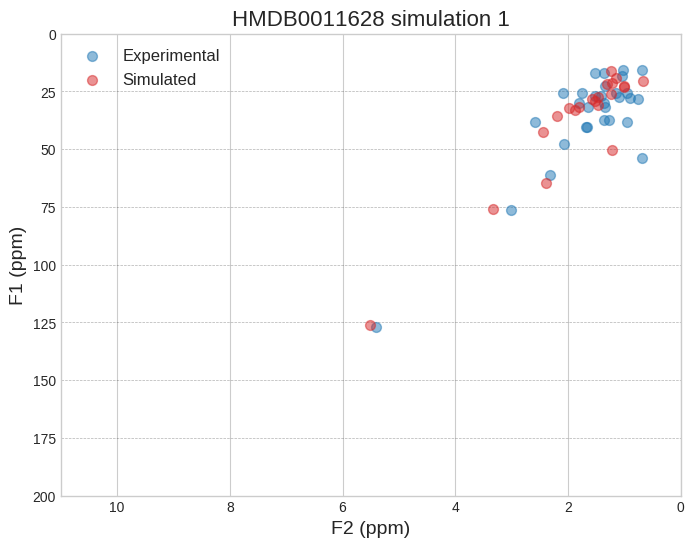

<ipython-input-8-2003bcc598d6>:382: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')  # Use seaborn-style grid


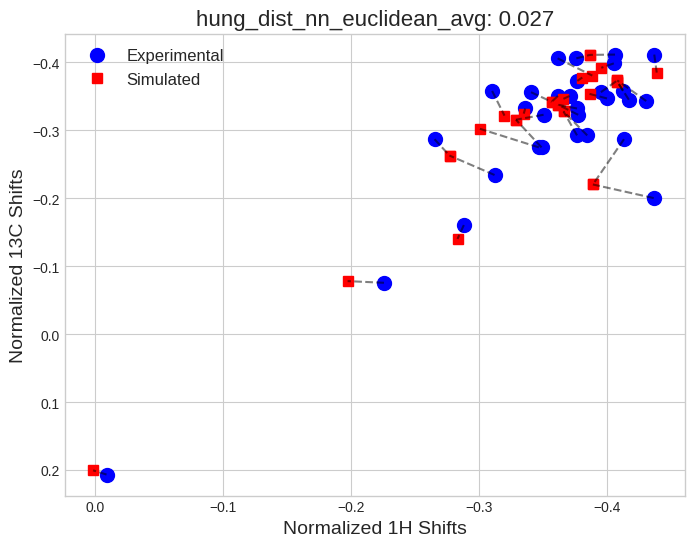

<ipython-input-8-2003bcc598d6>:45: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')  # Use seaborn-style grid


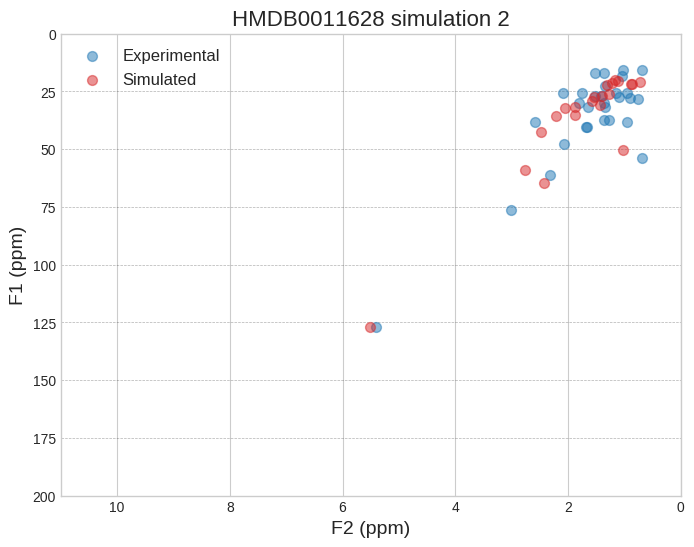

<ipython-input-8-2003bcc598d6>:382: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')  # Use seaborn-style grid


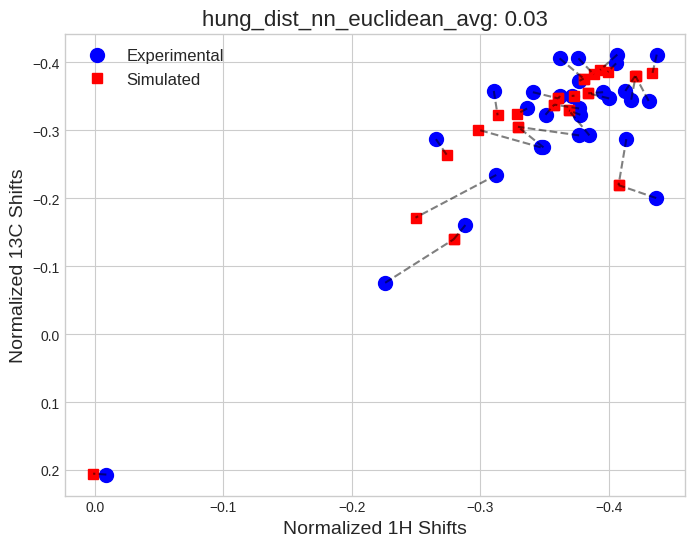

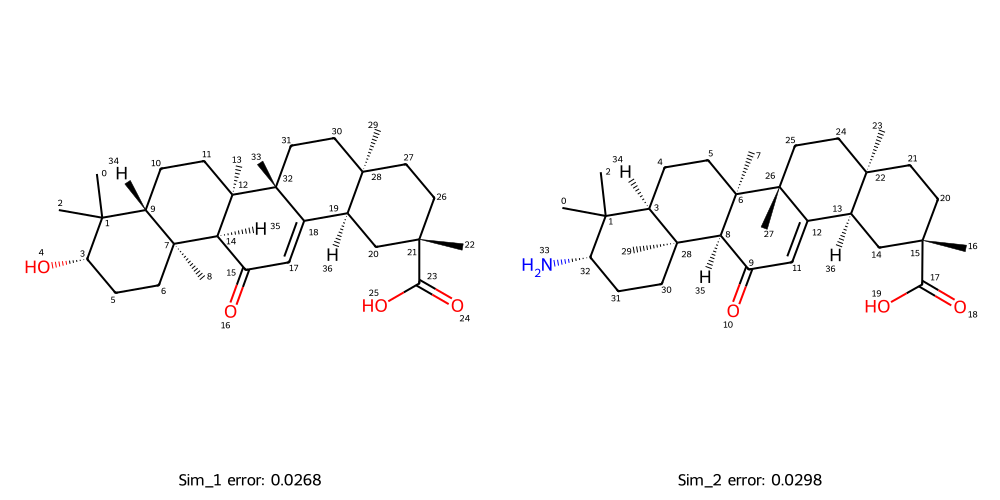

In [ ]:
#@title ##**3.3. Select Simulation Technique**
error = "avg" #  or "sum"
display_img = True
similarity_type="euclidean"
mode_dict = {"hung_dist_nn":8, "hung_dist_trunc":5,"hung_dist_zero":2,"euc_dist_nn":7,"euc_dist_trunc":4,"euc_dist_zero":1,"min_sum_nn":6,"min_sum_trunc":3,"min_sum_zero":0,}

#@markdown **Provide Experimental and Simulated File Paths**
experimental_file = "/content/hsqc_structure_elucidation/sample_file/HMDB0011628_nmrtwod_1983_36663.txt"#@param {type:"string"}
simulated_file1 = "/content/sample/NMR_smiles_1.sdf"#@param {type:"string"}
simulated_file2 = "/content/sample/NMR_smiles_2.sdf"#@param {type:"string"}

#@markdown **Choose Simulation Technique**
#@markdown - ACD -> ACD Labs (Commercial Software)
#@markdown - MNova -> MestroNova (Commercial Software)
#@markdown - DFT -> DFT calculation
#@markdown - ML -> Machine Learning method (SGNN -created in Section 2)
simulation_technique = "ML" #@param ["ACD", "MNova", "DFT", "ML"]

#@markdown **Choose matching strategy**
#@markdown - HungDist -> Hungarian Distance Algorithm
#@markdown - EucDist -> Euclidean Distance Algorithm
#@markdown - MinSum -> Minimun Sum Sorting
matching_technique = "HungDist" #@param ["HungDist","EucDist", "MinSum"]

#@markdown **Choose padding strategy**
#@markdown - NN -> Nearest Neighbor double assignment
#@markdown - Trunc -> Peak Truncation
#@markdown - Zero ->Zero Padding
padding_technique = "NN" #@param ["NN", "Trunc", "Zero"]

# Construct mode
if matching_technique == "HungDist":
  matching ="hung_dist_"
elif matching_technique == "EucDist":
  matching ="euc_dist_"
elif matching_technique == "MinSum":
  matching ="min_sum_"
if padding_technique == "NN":
  pad = "nn"
elif padding_technique == "Trunc":
  pad = "trunc"
elif padding_technique == "Zero":
  pad = "zero"
mode = matching+pad


try:
  if simulation_technique == "ACD":
    sim_df1 = load_acd_dataframe_from_file(simulated_file1)
    sim_df2 = load_acd_dataframe_from_file(simulated_file2)
  elif simulation_technique == "MNova":
    sim_df1 = load_mnova_dataframe_from_file(simulated_file1)
    sim_df2 = load_mnova_dataframe_from_file(simulated_file2)
  elif simulation_technique == "DFT":

    sim_df1 = load_dft_dataframe_from_file(simulated_file1)
    sim_df2 = load_dft_dataframe_from_file(simulated_file2)
  elif simulation_technique == "ML":
    sim_df1 = load_ml_dataframe_from_file(simulated_file1)
    sim_df2 = load_ml_dataframe_from_file(simulated_file2)
except:
  print("Maybe you have chosen the wrong simulation technique or not provided a valid file. ")
  print("Please check the source files and try again!")
try: ### Either load data form HMDB examples
  df_real, sample_id = load_real_df_from_txt_path(experimental_file)
except: ### or from the manual selected picked peaks using MNova Software
  df_real = load_mnova_dataframe_from_file(experimental_file)
label_fig1 = sample_id + " simulation 1"
results_real_sim1, _ = get_similarity_comparison_variations(df_real, sim_df1, mode, label_fig1, similarity_type=similarity_type, error=error, display_img=display_img)
label_fig2 = sample_id + " simulation 2"
results_real_sim2, _ = get_similarity_comparison_variations(df_real, sim_df2, mode, label_fig2, similarity_type=similarity_type, error=error, display_img=display_img)

#### DISPLAY the simulated molecules
if not simulation_technique=="MNova":
  idx = mode_dict[mode]
  mol_1_sim = results_real_sim1[idx]
  mol_2_sim = results_real_sim2[idx]

  # List of molecules and their labels
  # Load the molecules from sdf files

  molecule1 = Chem.SDMolSupplier(simulated_file1)[0]
  molecule2 = Chem.SDMolSupplier(simulated_file2)[0]

  molecules = [molecule1, molecule2]
  labels = [f'Sim_1 error: {round(float(mol_1_sim),4)}', f'Sim_2 error: {round(float(mol_2_sim),4)}']  # replace with your labels

  # Generate image
  #display(Draw.MolsToGridImage(molecules, legends=labels, molsPerRow=2))
  #sanitize Molecules

  molecules = [molecule1, molecule2]
  molecule1_san=Chem.MolFromSmiles(Chem.MolToSmiles(molecule1))
  molecule2_san=Chem.MolFromSmiles(Chem.MolToSmiles(molecule2))
  molecules_san = [molecule1_san, molecule2_san]
  #display(Draw.MolsToGridImage(molecules_san, legends=labels, molsPerRow=2), subImgSize=(500, 500))
  img = Draw.MolsToGridImage(molecules_san, legends=labels, molsPerRow=2, subImgSize=(500, 500)) # increase the tuple numbers for bigger image

  # Display the image
  display(img)

  #@markdown If MNova is selected there the molecule will not be displayed since the input file does not contain the structure

  #@markdown **THE LOWER THE NUMBER THE BETTER THE MATCH. Number corresponds to the match error**
